# TP53 Graph Classification - Main Experiment
Predicting TP53 mutation status using single-cell RNA-seq and Graph Neural Networks.


# Setup

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import mygene
sys.path.append(os.path.abspath("../src"))
import importlib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats
import math
from torch_geometric.transforms import LargestConnectedComponents
import torch_geometric.utils as tg_utils
from torch_geometric.data import Data 
import networkx as nx
import torch
import seaborn as sns
import gc
from pathlib import Path
import scanpy.external as sce
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb


import load_data
import preprocessing
import network_constructor
import model_constructor
import model_comparison
import preliminary_checks
import target_genes_check

/opt/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data import 

In [147]:
adata = load_data.load_expression_data( "../data/Expression_Matrix", verbosity=True)
df_expression=ad.AnnData.to_df(adata)
df_expression.head()


df_expression shape: (35276, 47096)
df_expression columns: Index(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457',
       'ENSG00000000460', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167', 'ENSG00000001460', 'ENSG00000001461',
       'ENSG00000001497',
       ...
       'ENSG00000271681', 'ENSG00000276605', 'ENSG00000277206',
       'ENSG00000277591', 'ENSG00000278658', 'ENSG00000279270',
       'ENSG00000280920', 'ENSG00000283420', 'ENSG00000284003',
       'ENSG00000284685'],
      dtype='object', length=47096)
df_expression head:                     ENSG00000000003  ENSG00000000419  ENSG00000000457  \
AU565_AAACCAGTTTGG              0.0              2.0              0.0   
AU565_AAACGTGCAGCG              1.0              0.0              0.0   
AU565_AAAGCCACATGC              0.0              2.0              0.0   
AU565_AAAGTCGGCTGG              0.0              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0              2.0              0.0   

ENSG00000000003  ENSG00000000419  ENSG00000000457  \
AU565_AAACCAGTTTGG              0.0              2.0              0.0   
AU565_AAACGTGCAGCG              1.0              0.0              0.0   
AU565_AAAGCCACATGC              0.0              2.0              0.0   
AU565_AAAGTCGGCTGG              0.0              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0              2.0              0.0   

                    ENSG00000000460  ENSG00000001036  ENSG00000001084  \
AU565_AAACCAGTTTGG              1.0              1.0              0.0   
AU565_AAACGTGCAGCG              0.0              1.0              0.0   
AU565_AAAGCCACATGC              0.0              0.0              0.0   
AU565_AAAGTCGGCTGG              0.0              1.0              0.0   
AU565_AAAGTGCCTAAA              0.0              1.0              0.0   

                    ENSG00000001167  ENSG00000001460  ENSG00000001461  \
AU565_AAACCAGTTTGG              0.0              0.0              0.0   
AU565_AAACGTGCAGCG              0.0              0.0              0.0   
AU565_AAAGCCACATGC              0.0              0.0              0.0   
AU565_AAAGTCGGCTGG              0.0              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0              0.0              1.0   

                    ENSG00000001497  ...  ENSG00000271681  ENSG00000276605  \
AU565_AAACCAGTTTGG              0.0  ...              0.0              0.0   
AU565_AAACGTGCAGCG              0.0  ...              0.0              0.0   
AU565_AAAGCCACATGC              0.0  ...              0.0              0.0   
AU565_AAAGTCGGCTGG              1.0  ...              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0  ...              0.0              0.0   

                    ENSG00000277206  ENSG00000277591  ENSG00000278658  \
AU565_AAACCAGTTTGG              0.0              0.0              0.0   
AU565_AAACGTGCAGCG              0.0              0.0              0.0   
AU565_AAAGCCACATGC              0.0              0.0              0.0   
AU565_AAAGTCGGCTGG              0.0              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0              0.0              0.0   

                    ENSG00000279270  ENSG00000280920  ENSG00000283420  \
AU565_AAACCAGTTTGG              0.0              0.0              0.0   
AU565_AAACGTGCAGCG              0.0              0.0              0.0   
AU565_AAAGCCACATGC              0.0              0.0              0.0   
AU565_AAAGTCGGCTGG              0.0              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0              0.0              0.0   

                    ENSG00000284003  ENSG00000284685  
AU565_AAACCAGTTTGG              0.0              0.0  
AU565_AAACGTGCAGCG              0.0              0.0  
AU565_AAAGCCACATGC              0.0              0.0  
AU565_AAAGTCGGCTGG              0.0              0.0  
AU565_AAAGTGCCTAAA              0.0              0.0  

[5 rows x 47096 columns]

In [148]:
df_mutation = load_data.load_mutation_data("../data/Mutation/CellLineDownload_r21.csv", verbosity=True)
df_mutation = load_data.add_cleaned_column(df_mutation, column_name="Sample_Name")
df_mutation.head()

df_mutation shape: (2913, 80)
df_mutation columns: Index(['Sample_Name', 'ATCC_ID', 'Cosmic_ID', 'Short_topo', 'Morphology',
       'Tumor_origin', 'Add_info', 'Sex', 'Age', 'Country', 'Population',
       'Germline_mutation', 'Infectious_agent', 'Tobacco', 'Alcohol',
       'Exposure', 'KRAS_status', 'Other_mutations', 'TP53status', 'p53_IHC',
       'TP53_LOH', 'MUT_ID', 'hg18_Chr17_coordinates',
       'hg19_Chr17_coordinates', 'hg38_Chr17_coordinates', 'ExonIntron',
       'Codon_number', 'Description', 'Type', 'c_description', 'g_description',
       'g_description_GRCh38', 'WT_nucleotide', 'Mutant_nucleotide',
       'WT_codon', 'Mutant_codon', 'WT_AA', 'Mutant_AA', 'Effect',
       'ProtDescription', 'COSMIClink', 'TCGA_ICGC_GENIE_count', 'Hotspot',
       'AGVGDClass', 'SIFTClass', 'Polyphen2', 'REVEL', 'BayesDel',
       'StructureFunctionClass', 'TransactivationClass', 'DNEclass',
       'DNE_LOFclass', 'WAF1nWT', 'MDM2nWT', 'BAXnWT', 'AIP1nWT', 'h1433snWT',
       'GADD45nWT

Sample_Name    ATCC_ID  Cosmic_ID     Short_topo  \
Sample_ID                                                    
2946             SW13    CCL-105   909744.0  ADRENAL GLAND   
24833        NCI-H295  CRL-10296   908466.0  ADRENAL GLAND   
24979       NCI-H295R   CRL-2128        NaN  ADRENAL GLAND   
21569        NCI-H295  CRL-10296   908466.0  ADRENAL GLAND   
21329           ETK-1        NaN   906861.0  BILIARY TRACT   

                                   Morphology Tumor_origin  \
Sample_ID                                                    
2946       Adrenal cortical carcinoma (C74.0)          NaN   
24833      Adrenal cortical carcinoma (C74.0)          NaN   
24979      Adrenal cortical carcinoma (C74.0)      primary   
21569      Adrenal cortical carcinoma (C74.0)          NaN   
21329                     Adenocarcinoma, NOS          NaN   

                                  Add_info Sex   Age Country  ...  exon3  \
Sample_ID                                                     ...          
2946                                   NaN   F  55.0     NaN  ...  False   
24833                                  NaN   F  48.0     NaN  ...  False   
24979      Derived from NCI-H295 cell line   F  48.0     NaN  ...   True   
21569                                  NaN   F  48.0     NaN  ...   True   
21329                                  NaN   F   NaN     NaN  ...   True   

           exon4 exon5 exon6 exon7 exon8  exon9 exon10 exon11  \
Sample_ID                                                       
2946       False  True  True  True  True  False  False  False   
24833      False  True  True  True  True  False  False  False   
24979       True  True  True  True  True   True   True   True   
21569       True  True  True  True  True   True   True   True   
21329       True  True  True  True  True   True   True   True   

          Sample_Name_cleaned  
Sample_ID                      
2946                     SW13  
24833                 NCIH295  
24979                NCIH295R  
21569                 NCIH295  
21329                    ETK1  

[5 rows x 80 columns]

In [149]:
# #PER SALVARE PER PREPROCESSING SU CLUSTER
# df_mutation.to_csv("../data/preprocessing/Mutation_status_cleaned_column.csv")
# adata.write_h5ad("../data/preprocessing/Expression_Matrix_raw.h5ad")

# Preliminary Checks

## XGboost on full dataset bulk data

In [25]:
df_bulk=pd.read_csv("../data/Target_genes/BulkCCLE_da_michele.csv")
df_bulk["mutation_type"]= np.where(df_bulk["mutation_type"]=="wt","wt","mut" )
df_bulk.columns=[col.split(" ")[0].strip() for col in df_bulk.columns]

mask = df_bulk["mutation_type"]=="wt"
print(f"n wt: {df_bulk[mask].shape[0]}")
print(f"n mut: {df_bulk[~mask].shape[0]}")
df_bulk['mutation_type'] = df_bulk['mutation_type'].map({'mut': 1, 'wt': 0})

n wt: 524
n mut: 969


In [19]:
import xgboost as xgb
X = df_bulk.drop(columns=['mutation_type',"Unnamed:"])
y = df_bulk['mutation_type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:05:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8494983277591973
Precision: 0.8465116279069768
Recall: 0.9381443298969072
F1 Score: 0.8899755501222494
AUC: 0.9001472754050074


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


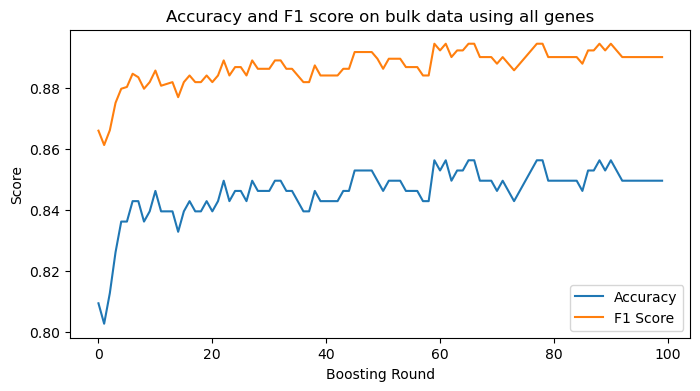

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

X = df_bulk.drop(columns=['mutation_type', "Unnamed:"])
y = df_bulk['mutation_type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

evals_result = model.evals_result()

epochs = len(evals_result['validation_0']['logloss'])
acc_list = []
f1_list = []
for i in range(epochs):
    try:
        y_pred = model.predict(X_test, iteration_range=(0, i+1))
    except TypeError:
        y_pred = model.predict(X_test, ntree_limit=i+1)
    acc_list.append(accuracy_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))

plt.figure(figsize=(8,4))
plt.plot(acc_list, label='Accuracy')
plt.plot(f1_list, label='F1 Score')
plt.xlabel('Boosting Round')
plt.ylabel('Score')
plt.title('Accuracy and F1 score on bulk data using all genes')
plt.legend()
plt.show()

## XGboost on TP53 target bulk data

In [27]:
df_bulk=pd.read_csv("../data/Target_genes/BulkCCLE_da_michele.csv")
df_bulk["mutation_type"]= np.where(df_bulk["mutation_type"]=="wt","wt","mut" )
df_bulk.columns=[col.split(" ")[0].strip() for col in df_bulk.columns]

mask = df_bulk["mutation_type"]=="wt"
print(f"n wt: {df_bulk[mask].shape[0]}")
print(f"n mut: {df_bulk[~mask].shape[0]}")
df_bulk['mutation_type'] = df_bulk['mutation_type'].map({'mut': 1, 'wt': 0})

n wt: 524
n mut: 969


In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
tab1 = pd.read_excel('../data/Target_genes/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx')
target_genes = [gene for gene in tab1["Gene Symbol"] if gene in df_bulk.columns]
X = df_bulk[target_genes]
y = df_bulk['mutation_type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:07:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8361204013377926
Precision: 0.8372093023255814
Recall: 0.9278350515463918
F1 Score: 0.8801955990220048
AUC: 0.8932253313696612


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:07:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


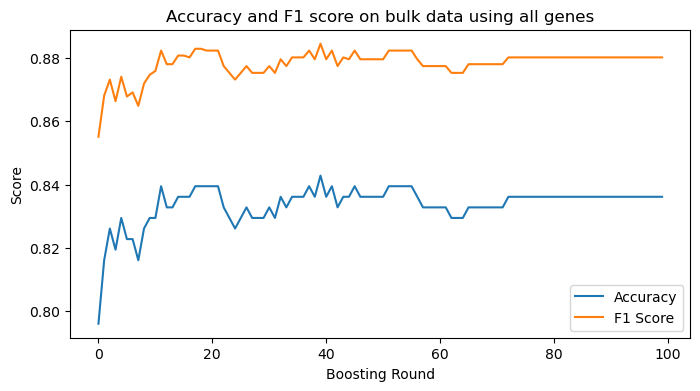

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

#Get target genes 
tab1 = pd.read_excel('../data/Target_genes/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx')
target_genes = [gene for gene in tab1["Gene Symbol"] if gene in df_bulk.columns]

#Filter df_bulk for only target genes
X = df_bulk[target_genes]
y = df_bulk['mutation_type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)


evals_result = model.evals_result()

epochs = len(evals_result['validation_0']['logloss'])
acc_list = []
f1_list = []
for i in range(epochs):
    try:
        y_pred = model.predict(X_test, iteration_range=(0, i+1))
    except TypeError:
        y_pred = model.predict(X_test, ntree_limit=i+1)
    acc_list.append(accuracy_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))

plt.figure(figsize=(8,4))
plt.plot(acc_list, label='Accuracy')
plt.plot(f1_list, label='F1 Score')
plt.xlabel('Boosting Round')
plt.ylabel('Score')
plt.title('Accuracy and F1 score on bulk data using all genes')
plt.legend()
plt.show()

## XGBoost on full dataset single cell

### XGB HVGs

In [152]:
df = pd.read_csv("final_preprocessed_data_HVG_.csv", index_col=0)
df

ENSG00000001084  ENSG00000001461  ENSG00000002834  \
AU565_AAACCAGTTTGG              0.0         0.000000              0.0   
AU565_AAACGTGCAGCG              0.0         0.000000              0.0   
AU565_AAAGCCACATGC              0.0         0.000000              0.0   
AU565_AAAGTCGGCTGG              0.0         0.000000              0.0   
AU565_AAAGTGCCTAAA              0.0         0.802482              0.0   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA              0.0         0.000000              0.0   
ZR751_TTTGGCCGGCAT              0.0         0.331385              0.0   
ZR751_TTTTAGCCGTGA              0.0         0.748973              0.0   
ZR751_TTTTGATATCCG              0.0         0.000000              0.0   
ZR751_TTTTGCACACTA              0.0         0.000000              0.0   

                    ENSG00000005884  ENSG00000006282  ENSG00000006459  \
AU565_AAACCAGTTTGG              0.0         0.000000         0.000000   
AU565_AAACGTGCAGCG              0.0         0.751924         0.000000   
AU565_AAAGCCACATGC              0.0         0.000000         0.000000   
AU565_AAAGTCGGCTGG              0.0         0.000000         0.925356   
AU565_AAAGTGCCTAAA              0.0         0.000000         0.000000   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA              0.0         0.000000         1.002698   
ZR751_TTTGGCCGGCAT              0.0         0.331385         0.000000   
ZR751_TTTTAGCCGTGA              0.0         0.748973         0.000000   
ZR751_TTTTGATATCCG              0.0         0.838929         0.000000   
ZR751_TTTTGCACACTA              0.0         0.000000         0.000000   

                    ENSG00000006757  ENSG00000007944  ENSG00000008283  \
AU565_AAACCAGTTTGG         0.000000         0.000000         0.000000   
AU565_AAACGTGCAGCG         0.751924         0.751924         0.751924   
AU565_AAAGCCACATGC         0.000000         0.000000         0.000000   
AU565_AAAGTCGGCTGG         0.000000         0.000000         0.925356   
AU565_AAAGTGCCTAAA         0.000000         0.000000         1.546118   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA         0.000000         0.000000         1.002698   
ZR751_TTTGGCCGGCAT         0.778723         0.000000         0.000000   
ZR751_TTTTAGCCGTGA         1.172375         0.000000         0.748973   
ZR751_TTTTGATATCCG         0.000000         0.000000         0.000000   
ZR751_TTTTGCACACTA         0.000000         0.647842         1.535930   

                    ENSG00000008838  ...  ENSG00000104371  ENSG00000188257  \
AU565_AAACCAGTTTGG              0.0  ...              0.0              0.0   
AU565_AAACGTGCAGCG              0.0  ...              0.0              0.0   
AU565_AAAGCCACATGC              0.0  ...              0.0              0.0   
AU565_AAAGTCGGCTGG              0.0  ...              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0  ...              0.0              0.0   
...                             ...  ...              ...              ...   
ZR751_TTTGGCCCTCGA              0.0  ...              0.0              0.0   
ZR751_TTTGGCCGGCAT              0.0  ...              0.0              0.0   
ZR751_TTTTAGCCGTGA              0.0  ...              0.0              0.0   
ZR751_TTTTGATATCCG              0.0  ...              0.0              0.0   
ZR751_TTTTGCACACTA              0.0  ...              0.0              0.0   

                    ENSG00000108700  ENSG00000167656  ENSG00000167779  \
AU565_AAACCAGTTTGG              0.0         0.000000              0.0   
AU565_AAACGTGCAGCG              0.0         0.000000              0.0   
AU565_AAAGCCACATGC              0.0         0.924988              0.0   
AU565_AAAGTCGGCTGG              0.0         0.000000              0.0   
AU565_AAAGTGCCTAAA              0.0         0.000000              0.0   
...           

In [153]:
X = df.drop(columns=["mutation_status"])
y = df['mutation_status']
y = np.where(y == 'WT', 0, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
model = xgb.XGBClassifier(random_state=42) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.9993488523522709
Precision: 0.9991425509110397
Recall: 1.0
F1 Score: 0.9995710915719493
AUC: 0.9999933406701775


### XGB Target genes

In [154]:
df_target = pd.read_csv("final_preprocessed_data_target_.csv", index_col=0)
df_target

ENSG00000144452  ENSG00000085563  ENSG00000107796  \
AU565_AAACCAGTTTGG         0.000000              0.0              0.0   
AU565_AAACGTGCAGCG         0.000000              0.0              0.0   
AU565_AAAGCCACATGC         0.000000              0.0              0.0   
AU565_AAAGTCGGCTGG         0.000000              0.0              0.0   
AU565_AAAGTGCCTAAA         0.000000              0.0              0.0   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA         1.002698              0.0              0.0   
ZR751_TTTGGCCGGCAT         0.331385              0.0              0.0   
ZR751_TTTTAGCCGTGA         1.172375              0.0              0.0   
ZR751_TTTTGATATCCG         0.000000              0.0              0.0   
ZR751_TTTTGCACACTA         0.000000              0.0              0.0   

                    ENSG00000181026  ENSG00000081051  ENSG00000042286  \
AU565_AAACCAGTTTGG         0.000000              0.0         0.854990   
AU565_AAACGTGCAGCG         0.000000              0.0         1.176238   
AU565_AAAGCCACATGC         0.000000              0.0         1.397154   
AU565_AAAGTCGGCTGG         0.000000              0.0         0.925356   
AU565_AAAGTGCCTAAA         0.000000              0.0         0.000000   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA         0.000000              0.0         1.493185   
ZR751_TTTGGCCGGCAT         0.331385              0.0         0.331385   
ZR751_TTTTAGCCGTGA         0.000000              0.0         1.172375   
ZR751_TTTTGATATCCG         0.000000              0.0         0.000000   
ZR751_TTTTGCACACTA         0.000000              0.0         0.000000   

                    ENSG00000011426  ENSG00000135046  ENSG00000169083  \
AU565_AAACCAGTTTGG         0.000000              0.0         0.000000   
AU565_AAACGTGCAGCG         0.751924              0.0         0.751924   
AU565_AAAGCCACATGC         0.000000              0.0         0.000000   
AU565_AAAGTCGGCTGG         0.925356              0.0         0.000000   
AU565_AAAGTGCCTAAA         1.241888              0.0         0.000000   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA         0.000000              0.0         1.002698   
ZR751_TTTGGCCGGCAT         0.000000              0.0         0.331385   
ZR751_TTTTAGCCGTGA         0.000000              0.0         0.000000   
ZR751_TTTTGATATCCG         0.000000              0.0         0.838929   
ZR751_TTTTGCACACTA         0.647842              0.0         0.000000   

                    ENSG00000116017  ...  ENSG00000067369  ENSG00000115129  \
AU565_AAACCAGTTTGG         0.000000  ...         0.000000         0.000000   
AU565_AAACGTGCAGCG         0.000000  ...         0.751924         0.000000   
AU565_AAAGCCACATGC         0.000000  ...         0.000000         0.000000   
AU565_AAAGTCGGCTGG         0.000000  ...         0.000000         0.000000   
AU565_AAAGTGCCTAAA         0.000000  ...         0.000000         0.000000   
...                             ...  ...              ...              ...   
ZR751_TTTGGCCCTCGA         0.000000  ...         1.002698         0.000000   
ZR751_TTTGGCCGGCAT         0.000000  ...         0.000000         0.331385   
ZR751_TTTTAGCCGTGA         0.000000  ...         0.000000         0.000000   
ZR751_TTTTGATATCCG         0.838929  ...         1.288620         0.838929   
ZR751_TTTTGCACACTA         0.647842  ...         1.037737         0.647842   

                    ENSG00000164938  ENSG00000132274  ENSG00000177169  \
AU565_AAACCAGTTTGG              0.0              0.0         0.000000   
AU565_AAACGTGCAGCG              0.0              0.0         0.000000   
AU565_AAAGCCACATGC              0.0              0.0         0.000000   
AU565_AAAGTCGGCTGG              0.0              0.0         0.000000   
AU565_AAAGTGCCTAAA              0.0              0.0         0.000000   
...           

In [155]:
X = df_target.drop(columns=["mutation_status"])
y = df_target['mutation_status']
y = np.where(y == 'WT', 0, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
model = xgb.XGBClassifier(random_state=42) 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.9923490151391828
Precision: 0.9933704020530368
Recall: 0.9965672602445828
F1 Score: 0.9949662632537217
AUC: 0.9991684523804354


In [156]:
df_bulk=pd.read_csv("../data/Target_genes/BulkCCLE_da_michele.csv")
df_bulk["mutation_type"]= np.where(df_bulk["mutation_type"]=="wt","wt","mut" )
df_bulk.columns=[col.split(" ")[0].strip() for col in df_bulk.columns]

mask = df_bulk["mutation_type"]=="wt"
print(f"n wt: {df_bulk[mask].shape[0]}")
print(f"n mut: {df_bulk[~mask].shape[0]}")
df_bulk['mutation_type'] = df_bulk['mutation_type'].map({'mut': 1, 'wt': 0})

n wt: 524
n mut: 969


In [157]:
import xgboost as xgb
X = df_bulk.drop(columns=['mutation_type',"Unnamed:"])
y = df_bulk['mutation_type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:13:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8494983277591973
Precision: 0.8465116279069768
Recall: 0.9381443298969072
F1 Score: 0.8899755501222494
AUC: 0.9001472754050074


## Small test (GCN con una mut e una wt nel train e idem nel test)

In [158]:
df = pd.read_csv("final_preprocessed_data_HVG_.csv", index_col=0)
df

ENSG00000001084  ENSG00000001461  ENSG00000002834  \
AU565_AAACCAGTTTGG              0.0         0.000000              0.0   
AU565_AAACGTGCAGCG              0.0         0.000000              0.0   
AU565_AAAGCCACATGC              0.0         0.000000              0.0   
AU565_AAAGTCGGCTGG              0.0         0.000000              0.0   
AU565_AAAGTGCCTAAA              0.0         0.802482              0.0   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA              0.0         0.000000              0.0   
ZR751_TTTGGCCGGCAT              0.0         0.331385              0.0   
ZR751_TTTTAGCCGTGA              0.0         0.748973              0.0   
ZR751_TTTTGATATCCG              0.0         0.000000              0.0   
ZR751_TTTTGCACACTA              0.0         0.000000              0.0   

                    ENSG00000005884  ENSG00000006282  ENSG00000006459  \
AU565_AAACCAGTTTGG              0.0         0.000000         0.000000   
AU565_AAACGTGCAGCG              0.0         0.751924         0.000000   
AU565_AAAGCCACATGC              0.0         0.000000         0.000000   
AU565_AAAGTCGGCTGG              0.0         0.000000         0.925356   
AU565_AAAGTGCCTAAA              0.0         0.000000         0.000000   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA              0.0         0.000000         1.002698   
ZR751_TTTGGCCGGCAT              0.0         0.331385         0.000000   
ZR751_TTTTAGCCGTGA              0.0         0.748973         0.000000   
ZR751_TTTTGATATCCG              0.0         0.838929         0.000000   
ZR751_TTTTGCACACTA              0.0         0.000000         0.000000   

                    ENSG00000006757  ENSG00000007944  ENSG00000008283  \
AU565_AAACCAGTTTGG         0.000000         0.000000         0.000000   
AU565_AAACGTGCAGCG         0.751924         0.751924         0.751924   
AU565_AAAGCCACATGC         0.000000         0.000000         0.000000   
AU565_AAAGTCGGCTGG         0.000000         0.000000         0.925356   
AU565_AAAGTGCCTAAA         0.000000         0.000000         1.546118   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA         0.000000         0.000000         1.002698   
ZR751_TTTGGCCGGCAT         0.778723         0.000000         0.000000   
ZR751_TTTTAGCCGTGA         1.172375         0.000000         0.748973   
ZR751_TTTTGATATCCG         0.000000         0.000000         0.000000   
ZR751_TTTTGCACACTA         0.000000         0.647842         1.535930   

                    ENSG00000008838  ...  ENSG00000104371  ENSG00000188257  \
AU565_AAACCAGTTTGG              0.0  ...              0.0              0.0   
AU565_AAACGTGCAGCG              0.0  ...              0.0              0.0   
AU565_AAAGCCACATGC              0.0  ...              0.0              0.0   
AU565_AAAGTCGGCTGG              0.0  ...              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0  ...              0.0              0.0   
...                             ...  ...              ...              ...   
ZR751_TTTGGCCCTCGA              0.0  ...              0.0              0.0   
ZR751_TTTGGCCGGCAT              0.0  ...              0.0              0.0   
ZR751_TTTTAGCCGTGA              0.0  ...              0.0              0.0   
ZR751_TTTTGATATCCG              0.0  ...              0.0              0.0   
ZR751_TTTTGCACACTA              0.0  ...              0.0              0.0   

                    ENSG00000108700  ENSG00000167656  ENSG00000167779  \
AU565_AAACCAGTTTGG              0.0         0.000000              0.0   
AU565_AAACGTGCAGCG              0.0         0.000000              0.0   
AU565_AAAGCCACATGC              0.0         0.924988              0.0   
AU565_AAAGTCGGCTGG              0.0         0.000000              0.0   
AU565_AAAGTGCCTAAA              0.0         0.000000              0.0   
...           

In [159]:
df["cell_line"] = df.index.str.split("_").str[0]
mut_train = df[df["mutation_status"] == "MUT"]["cell_line"].unique()[0]
wt_train = df[df["mutation_status"] == "WT"]["cell_line"].unique()[0]
df_train_subset = df[(df["cell_line"] == mut_train) | (df["cell_line"] == wt_train)]
mut_test = df[df["mutation_status"] == "MUT"]["cell_line"].unique()[1]
wt_test = df[df["mutation_status"] == "WT"]["cell_line"].unique()[1]
df_test_subset = df[(df["cell_line"] == mut_test) | (df["cell_line"] == wt_test)]
df_train_subset = df_train_subset.iloc[:, :-1]
df_test_subset = df_test_subset.iloc[:,:-1]

In [160]:
df_train_subset.to_csv("df_train_subset.csv")
df_test_subset.to_csv("df_test_subset.csv")

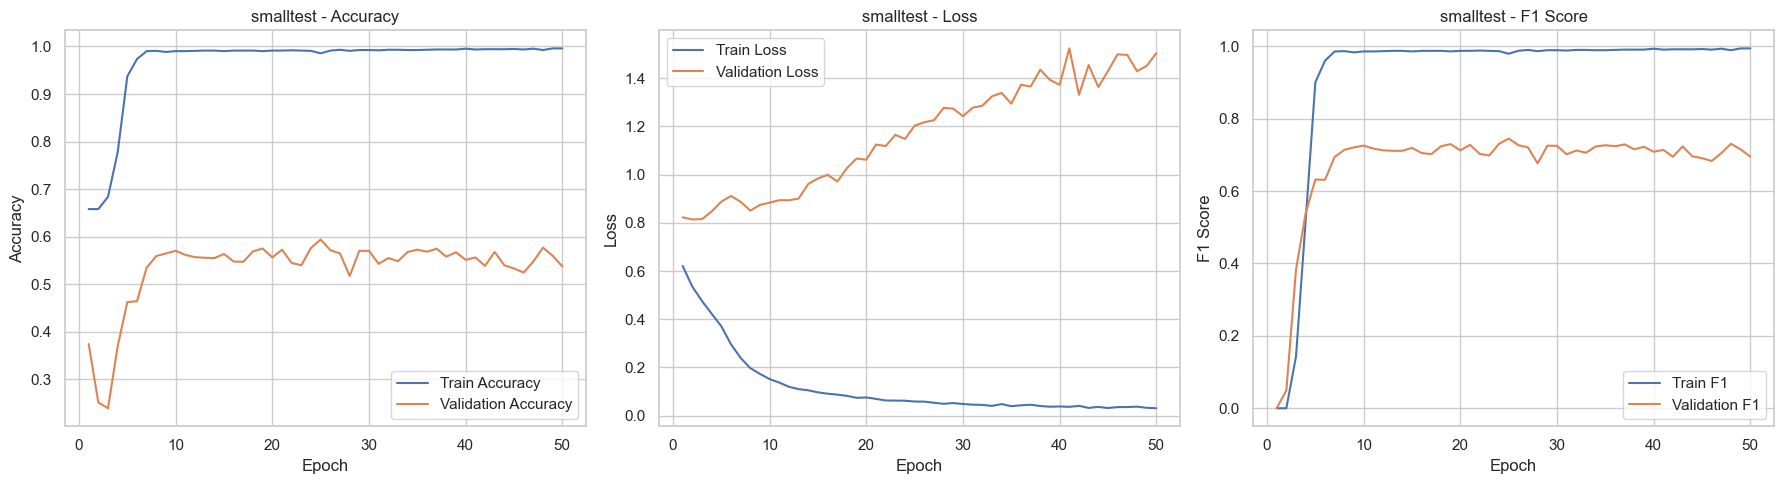

In [161]:
model_comparison.plot_training_curves("../Results/HVG/gat_results/smalltest/training_log.csv", model_name = "smalltest")

## 3X Subsampled-Balanced XGBoost on single cell lines

In [162]:
df = pd.read_csv("final_preprocessed_data_HVG_.csv", index_col=0)

In [163]:
results = preliminary_checks.nested_cv_holdout_xgboost(df, label_col="mutation_status", n_splits=5)
print(results)

Outer fold 1/5 (test block)


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:14:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:14:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:14:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:14:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Outer fold 2/5 (test block)


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:14:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:15:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:15:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:15:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Outer fold 3/5 (test block)


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:15:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:16:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:16:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:16:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Outer fold 4/5 (test block)


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Outer fold 5/5 (test block)


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:18:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:18:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:18:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:18:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

   Outer Fold  Mean Inner Accuracy  Mean Inner F1  Test Accuracy   Test F1
0           1             0.999308       0.999544       1.000000  1.000000
1           2             0.999715       0.999812       0.999186  0.999463
2           3             0.999512       0.999678       0.999674  0.999785
3           4             0.999430       0.999624       0.999349  0.999570
4           5             0.999634       0.999758       0.999837  0.999893


## Simple XGB single cell balanced subsampled 

In [164]:
df = pd.read_csv("final_preprocessed_data_HVG_.csv", index_col=0)

In [165]:
results = preliminary_checks.xgboost_balanced_subsample(df)
print(results)

Run 1/3


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:19:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 2/3


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:19:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Run 3/3


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:19:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   Run  Accuracy  F1 Score
0    1    0.9900  0.989899
1    2    0.9975  0.997494
2    3    0.9900  0.989950


## Binning exploration

In [ ]:
# Load the normal bulk
df_bulk = pd.read_csv("../data/Target_genes/BulkCCLE_da_michele.csv",index_col=0)
mutation_col = "mutation_type"
df_bulk[mutation_col] = np.where(df_bulk[mutation_col] == "wt", "wt", "mut")
df_bulk.columns = [col.split(" ")[0].strip() for col in df_bulk.columns]

# Prepare the data (exclude mutation_type column for transformations)
X = df_bulk.drop(columns=[mutation_col]).values

# Apply transformations and save the files
binned_20 = preprocessing.bin_data(X, n_bins=20)
binned_50 = preprocessing.bin_data(X, n_bins=50)
binned_100 = preprocessing.bin_data(X, n_bins=100)
cdfed = preprocessing.cdf_data(X)
ranked = preprocessing.rank_data(X)
avg_ranked = preprocessing.avg_rank_data(X)

columns = df_bulk.drop(columns=[mutation_col]).columns
for arr, name in zip([binned_20, binned_50, binned_100, cdfed, ranked, avg_ranked],
                     ["binned20", "binned50", "binned100", "cdfed", "ranked", "avg_ranked"]):
    df_new = pd.DataFrame(arr, columns=columns)
    df_new[mutation_col] = df_bulk[mutation_col].values
    out_path = f"../data/Target_genes/BulkCCLE_da_michele_{name}.csv"
    df_new.to_csv(out_path, index=False)

# Count the observations per class in all versions
bulk_files = {
    "baseline": "../data/Target_genes/BulkCCLE_da_michele.csv",
    "binned: 20 bins": "../data/Target_genes/BulkCCLE_da_michele_binned20.csv",
    "binned: 50 bins": "../data/Target_genes/BulkCCLE_da_michele_binned50.csv",
    "binned: 100 bins": "../data/Target_genes/BulkCCLE_da_michele_binned100.csv",
    "cdfed": "../data/Target_genes/BulkCCLE_da_michele_cdfed.csv",
    "ranked": "../data/Target_genes/BulkCCLE_da_michele_ranked.csv",
    "avg_ranked": "../data/Target_genes/BulkCCLE_da_michele_avg_ranked.csv"
}


for name, path in bulk_files.items():
    df = pd.read_csv(path, index_col=0)
    mutation_col = "mutation_type"
    df[mutation_col] = np.where(df[mutation_col] == "wt", 0, 1)
    X = df.drop(columns=[mutation_col])
    y = df[mutation_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name.upper()}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:22:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



BASELINE:
Accuracy: 0.8494983277591973
F1 Score: 0.8899755501222494


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:22:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



BINNED: 20 BINS:
Accuracy: 0.8294314381270903
F1 Score: 0.8753056234718827


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:22:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



BINNED: 50 BINS:
Accuracy: 0.8361204013377926
F1 Score: 0.8801955990220048


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:22:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



BINNED: 100 BINS:
Accuracy: 0.822742474916388
F1 Score: 0.8697788697788698


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:22:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



CDFED:
Accuracy: 0.8394648829431438
F1 Score: 0.8846153846153846


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:22:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



RANKED:
Accuracy: 0.6488294314381271
F1 Score: 0.7870182555780934


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [12:22:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



AVG_RANKED:
Accuracy: 0.8361204013377926
F1 Score: 0.8813559322033898


# EDA and Preprocessing

In [166]:
#Gene mapping
preprocessing.get_genes_symbols(adata, "gene_symbols")
print(adata.var['gene_symbols_mapped'].unique())

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
22 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000227110', 2), ('ENSG00000228566', 2), ('ENSG00000280018', 2), ('E
930 input query terms found no hit:	['ENSG00000112096', 'ENSG00000130723', 'ENSG00000168078', 'ENSG00000189144', 'ENSG00000205485', 'ENS


['TSPAN6' 'DPM1' 'SCYL3' ... 'MIR4278' 'ENSG00000284003' 'ENSG00000284685']


In [167]:
#Add mutation status to adata
preprocessing.add_mutation_column(adata, df_mutation, cell_lines_column_name = "Sample_Name_cleaned", mutation_status_column="TP53status", new_obs_column="mutation_status")

Cell lines not found in df_mutation: ['HS578T' 'MCF12A' 'MX1' 'MDAMB453']
Removed 4562 cells with unknown mutation status.
Number matching lines: 30714
Percentage of matching cell: 87.07%


In [168]:
#sparsity
preprocessing.check_sparsity(adata)

Number of cells: 30714
Number of genes: 47096
Number of non-zero entries: 100804217
Sparsity: 93.03%


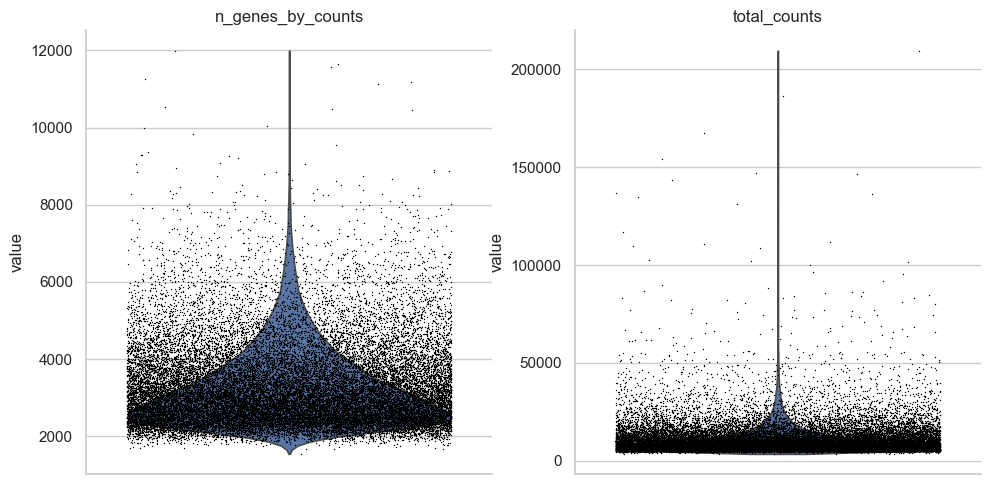

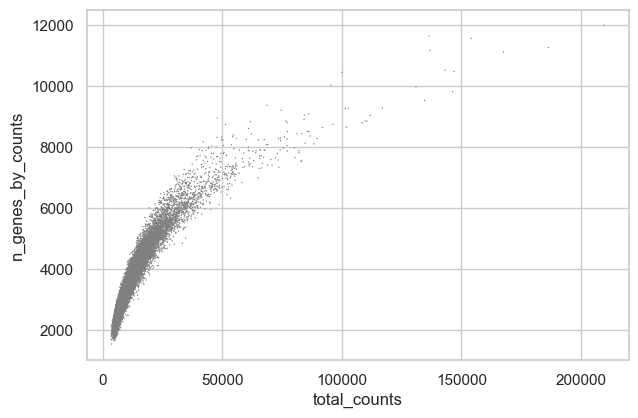

In [169]:
#Quality control
preprocessing.show_qc_plots(adata, violin_cols=['n_genes_by_counts', 'total_counts'], scatter_x='total_counts', scatter_y='n_genes_by_counts')

In [170]:
# #dublet detection     #COMPUTATIONALLY EXPENSIVE
# sc.pp.scrublet(adata)
# print(f"Number of doublets detected: {adata.obs['predicted_doublet'].sum()}")

In [171]:
#Normalization
adata.layers["raw_counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) 

In [ ]:
# #ComBat to correct batch effects      #WE RUN BATCH CORRECTION ON THE HPC CLUSTER USING jobs/preprocessing_run.sh
# adata.layers["pre_combat"] = adata.X.copy()
# sc.pp.combat(adata, key="cell_line")

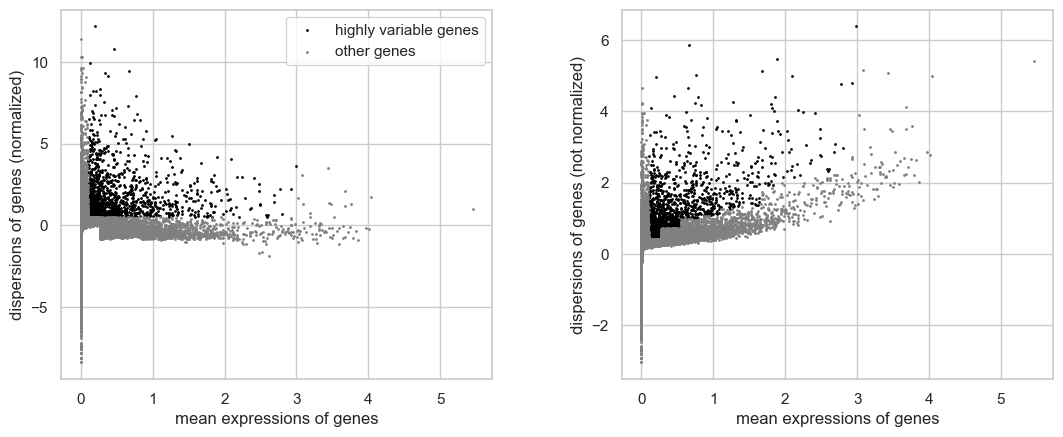

In [ ]:
#Feature selection
adata.layers["pre_feature_selection"] = adata.X.copy()


sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=3, min_disp=0.5 ) 
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]

/opt/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


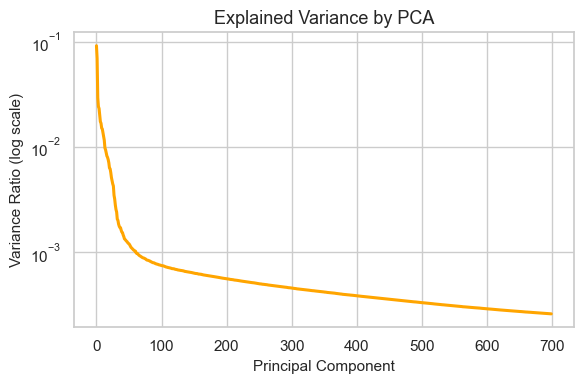

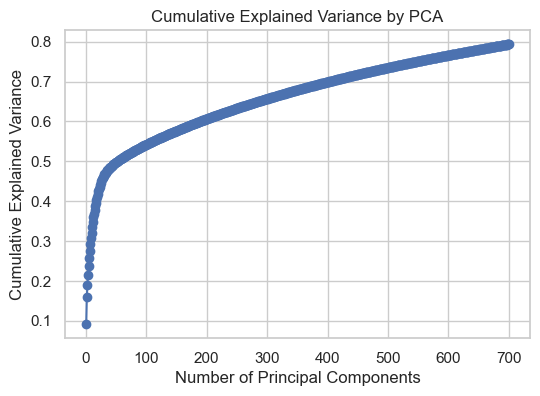

In [ ]:
sc.tl.pca(adata, n_comps=700)
#sc.pl.pca_variance_ratio(adata, n_pcs=700, log=True)
explained_variance = adata.uns['pca']['variance_ratio']
cumulative_variance = explained_variance.cumsum()
sns.set(style="whitegrid")

# Plot 1: Variance Ratio 
plt.figure(figsize=(6, 4))
plt.plot(explained_variance, linewidth=2.2, color="orange")
plt.title("Explained Variance by PCA", fontsize=13)
plt.xlabel("Principal Component", fontsize=11)
plt.ylabel("Variance Ratio (log scale)", fontsize=11)
plt.yscale('log')
plt.tight_layout()
plt.show()

# Plot 2: Cumulative Explained Variance 
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid(True)
plt.show()

In [175]:
adata.obs['cell_lines'] = adata.obs_names.str.split('_').str[0]

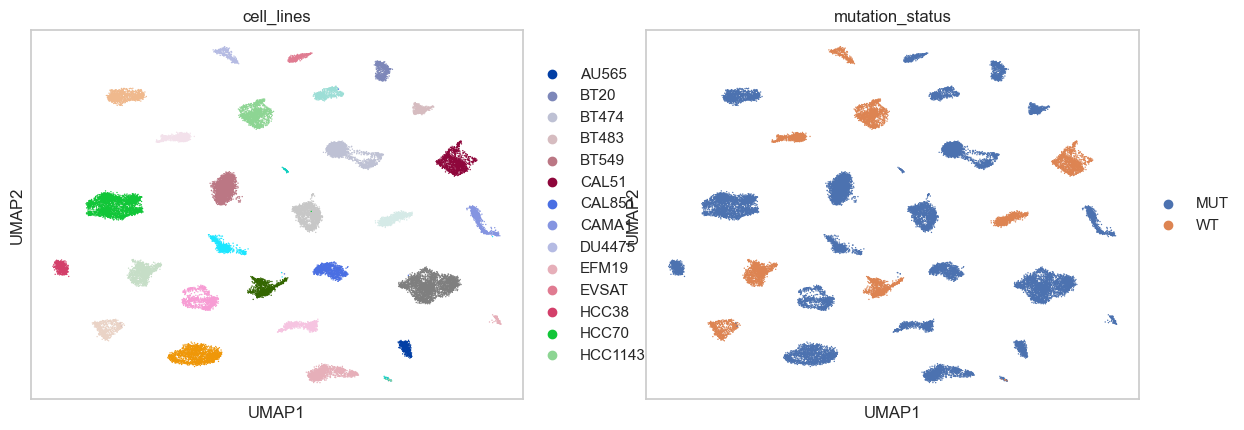

In [176]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ["cell_lines","mutation_status"]) 


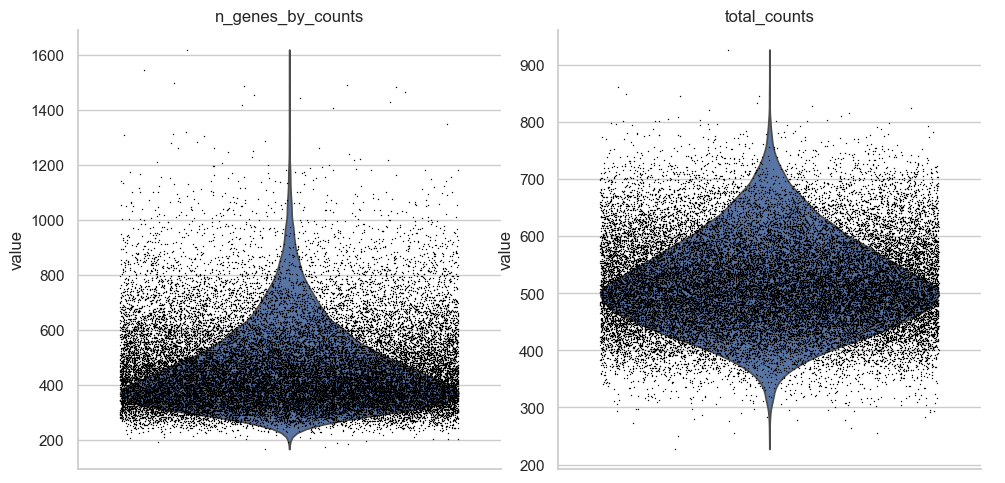

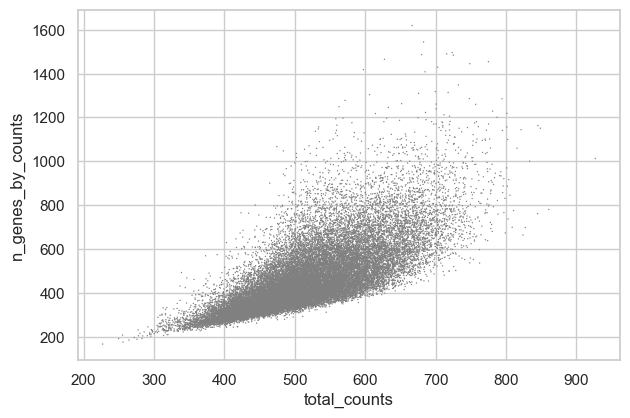

In [177]:
#Final Quality control
preprocessing.show_qc_plots(adata, violin_cols=['n_genes_by_counts', 'total_counts'], scatter_x='total_counts', scatter_y='n_genes_by_counts')

In [178]:
final_df = ad.AnnData.to_df(adata)
final_df["mutation_status"] = adata.obs["mutation_status"].values
final_df.head()

ENSG00000001084  ENSG00000001461  ENSG00000002834  \
AU565_AAACCAGTTTGG              0.0         0.000000              0.0   
AU565_AAACGTGCAGCG              0.0         0.000000              0.0   
AU565_AAAGCCACATGC              0.0         0.000000              0.0   
AU565_AAAGTCGGCTGG              0.0         0.000000              0.0   
AU565_AAAGTGCCTAAA              0.0         0.802482              0.0   

                    ENSG00000005884  ENSG00000006282  ENSG00000006459  \
AU565_AAACCAGTTTGG              0.0         0.000000         0.000000   
AU565_AAACGTGCAGCG              0.0         0.751924         0.000000   
AU565_AAAGCCACATGC              0.0         0.000000         0.000000   
AU565_AAAGTCGGCTGG              0.0         0.000000         0.925356   
AU565_AAAGTGCCTAAA              0.0         0.000000         0.000000   

                    ENSG00000006757  ENSG00000007944  ENSG00000008283  \
AU565_AAACCAGTTTGG         0.000000         0.000000         0.000000   
AU565_AAACGTGCAGCG         0.751924         0.751924         0.751924   
AU565_AAAGCCACATGC         0.000000         0.000000         0.000000   
AU565_AAAGTCGGCTGG         0.000000         0.000000         0.925356   
AU565_AAAGTGCCTAAA         0.000000         0.000000         1.546118   

                    ENSG00000008838  ...  ENSG00000104371  ENSG00000188257  \
AU565_AAACCAGTTTGG              0.0  ...              0.0              0.0   
AU565_AAACGTGCAGCG              0.0  ...              0.0              0.0   
AU565_AAAGCCACATGC              0.0  ...              0.0              0.0   
AU565_AAAGTCGGCTGG              0.0  ...              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0  ...              0.0              0.0   

                    ENSG00000108700  ENSG00000167656  ENSG00000167779  \
AU565_AAACCAGTTTGG              0.0         0.000000              0.0   
AU565_AAACGTGCAGCG              0.0         0.000000              0.0   
AU565_AAAGCCACATGC              0.0         0.924988              0.0   
AU565_AAAGTCGGCTGG              0.0         0.000000              0.0   
AU565_AAAGTGCCTAAA              0.0         0.000000              0.0   

                    ENSG00000122861  ENSG00000260549  ENSG00000127951  \
AU565_AAACCAGTTTGG              0.0              0.0              0.0   
AU565_AAACGTGCAGCG              0.0              0.0              0.0   
AU565_AAAGCCACATGC              0.0              0.0              0.0   
AU565_AAAGTCGGCTGG              0.0              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0              0.0              0.0   

                    ENSG00000170627  mutation_status  
AU565_AAACCAGTTTGG         0.000000              MUT  
AU565_AAACGTGCAGCG         0.000000              MUT  
AU565_AAAGCCACATGC         0.000000              MUT  
AU565_AAAGTCGGCTGG         0.925356              MUT  
AU565_AAAGTGCCTAAA         0.000000              MUT  

[5 rows x 2071 columns]

In [179]:
final_df.to_csv("final_preprocessed_data_HVG_.csv")

# Check on target genes

## single cell comparison

In [180]:
df = pd.read_csv("final_preprocessed_data_HVG_.csv", index_col=0)
df_target = pd.read_csv("final_preprocessed_data_target_.csv", index_col=0)
train_df, test_df = network_constructor.train_test_split(df, test_size=0.2, random_state=42)
print(f"shape del train test: {train_df.shape} \nshape del test set: {test_df.shape}")

shape del train test: (24571, 2071) 
shape del test set: (6143, 2071)


In [181]:
#import target genes and create target genes df
tab1 = pd.read_excel('../data/Target_genes/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx')
tab1_ensembl_ids = [gene for gene in tab1["Ensembl ID"] if gene in df.columns]
df_tab1 = df[tab1_ensembl_ids].copy()
mat_tab1=network_constructor.build_correlation_matrix(df_tab1, corr_threshold=0., p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_tab1)
mat_original=network_constructor.build_correlation_matrix(train_df.iloc[:,:-1], corr_threshold=0., p_value_threshold= 1,p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_original)


Percentage of non-zero values in the correlation matrix: 0.9893617021276596
Percentage of non-zero values in the correlation matrix: 0.9995169082125603


TAB1 è il csv con 350 target tp53 genes

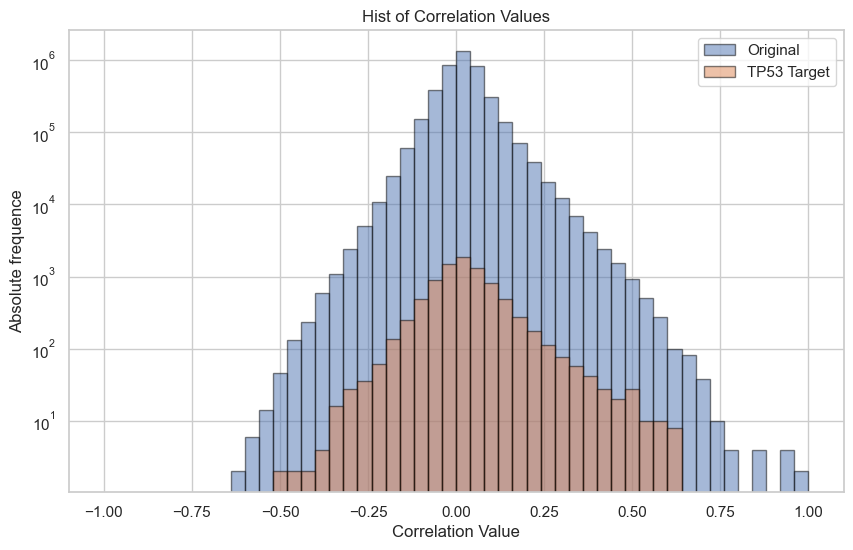

In [182]:
target_genes_check.plot_frequency_of_correlation_values({"Original":mat_original,"TP53 Target":mat_tab1})

In [183]:
from scipy.stats import ks_2samp
stat, pval = ks_2samp(mat_original.flatten(), mat_tab1.flatten())
print(f"KS: {stat}, p-value: {pval}")

KS: 0.10006603436635753, p-value: 2.5643336517681716e-77


## bulk data comparison

In [184]:
#import bulk data
df_bulk=pd.read_csv("../data/Target_genes/BulkCCLE_da_michele.csv")
df_bulk.head()

Unnamed: 0  KRT19 (3880)  SPARC (6678)  C19orf33 (64073)  VIM (7431)  \
0  ACH-001289      0.443607      6.943570          0.443607    9.940328   
1  ACH-000242     10.970609      0.739848          8.044886    1.748461   
2  ACH-000708      9.360715      2.632268          7.482203    3.140779   
3  ACH-000327      4.431623      0.823749          6.802839    1.475085   
4  ACH-001794      0.333424     13.167622          0.000000   11.982851   

   UCHL1 (7345)  TGFBI (7045)  KRT7 (3855)  RPS4Y1 (6192)  FN1 (2335)  ...  \
0      9.959553      0.378512     0.000000       8.705909    3.160275  ...   
1      1.384050      3.190615    11.812258       8.612463    3.427606  ...   
2      1.150560      5.874059     2.060047       0.948601    3.307429  ...   
3      5.741197      6.598574     9.222867       0.815575    4.015248  ...   
4      7.746178     10.725792     2.910733       0.042644   12.332764  ...   

   RGS11 (8786)  SLC3A1 (6519)  LIMK1 (3984)  SNX25 (83891)  VSIG10 (54621)  \
0      0.014355       0.042644      3.735522       5.757290        4.341986   
1      0.014355       0.042644      3.914565       2.049631        5.226894   
2      1.959770       2.944858      4.690976       1.992768        4.994580   
3      2.689299       1.400538      3.951401       1.526069        2.893362   
4      0.042644       0.042644      5.990047       3.923149        3.276497   

   TEDC1 (283643)  ZNF827 (152485)  CEP41 (95681)  RASD2 (23551)  \
0        2.914565         0.613532       0.495695       0.298658   
1        5.083213         2.189034       3.025029       0.014355   
2        4.728465         1.589763       1.280956       0.111031   
3        2.916477         2.166715       2.553361       0.443607   
4        3.476382         3.192194       1.918386       0.056584   

   mutation_type  
0             wt  
1             wt  
2             wt  
3             wt  
4             wt  

[5 rows x 6100 columns]

In [185]:
df_bulk["mutation_type"]= np.where(df_bulk["mutation_type"]=="wt","wt","mut" )
df_bulk.columns=[col.split(" ")[0].strip() for col in df_bulk.columns]
df_bulk_tab1_gene_symbol = [gene for gene in tab1["Gene Symbol"] if gene in df_bulk.columns]
df_tab1_bulk = df_bulk[df_bulk_tab1_gene_symbol].copy()

In [186]:
print(f"shape before target filtering: {df_bulk.shape}")
print(f"shape after target filtering: {df_tab1_bulk.shape}")
n_correspondence = len([col in df.columns[:-1]  for col in df_tab1_bulk.columns] )
print(f"check how many HVG are in target filtered:{n_correspondence} ")

shape before target filtering: (1493, 6100)
shape after target filtering: (1493, 200)
check how many HVG are in target filtered:200 


In [187]:
mat_original_bulk=network_constructor.build_correlation_matrix(df_bulk, corr_threshold=0, p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_original_bulk)
mat_tab1_bulk=network_constructor.build_correlation_matrix(df_tab1_bulk, corr_threshold=0, p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD
network_constructor.check_percentage_of_zeros(mat_tab1_bulk)

Percentage of non-zero values in the correlation matrix: 0.9998360655737705
Percentage of non-zero values in the correlation matrix: 0.995


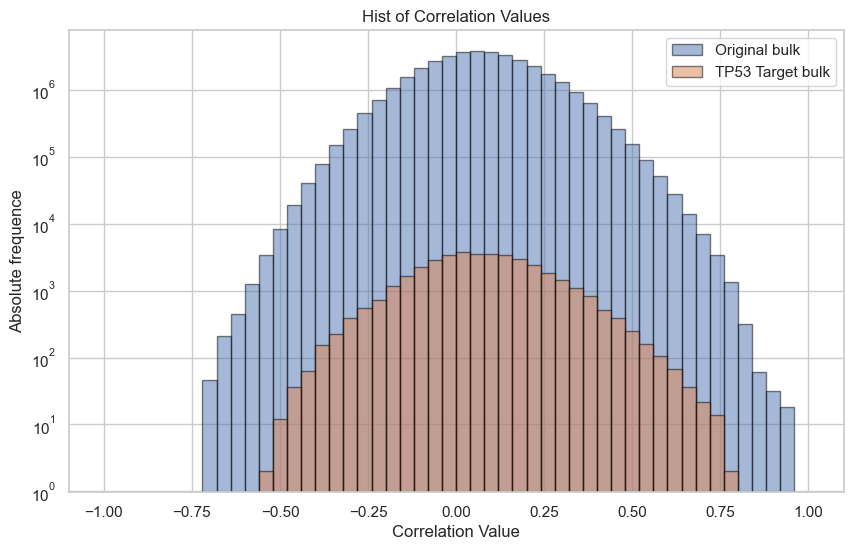

In [188]:
target_genes_check.plot_frequency_of_correlation_values({"Original bulk":mat_original_bulk,"TP53 Target bulk":mat_tab1_bulk})

## barplot divided by mut or wt

In [ ]:
#create target bulk dataframe
df_tab1_bulk_with_mutstatus = df_bulk[df_bulk_tab1_gene_symbol + ["mutation_type"]].copy()
df_tab1_bulk_with_mutstatus.shape

(1493, 201)

In [190]:
df_tab1_bulk_mut = df_tab1_bulk_with_mutstatus[ df_tab1_bulk_with_mutstatus["mutation_type"] == "mut" ].copy()
df_tab1_bulk_wt = df_tab1_bulk_with_mutstatus[ df_tab1_bulk_with_mutstatus["mutation_type"] == "wt" ].copy()
print(df_tab1_bulk_mut.shape)
print(df_tab1_bulk_wt.shape)
mat_target_bulk_mut = network_constructor.build_correlation_matrix(df_tab1_bulk_mut, corr_threshold=0, p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD
mat_target_bulk_wt =  network_constructor.build_correlation_matrix(df_tab1_bulk_wt, corr_threshold=0, p_value_threshold= 1, p_val="no") #PER ORA NO THRESHOLD

(969, 201)
(524, 201)


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


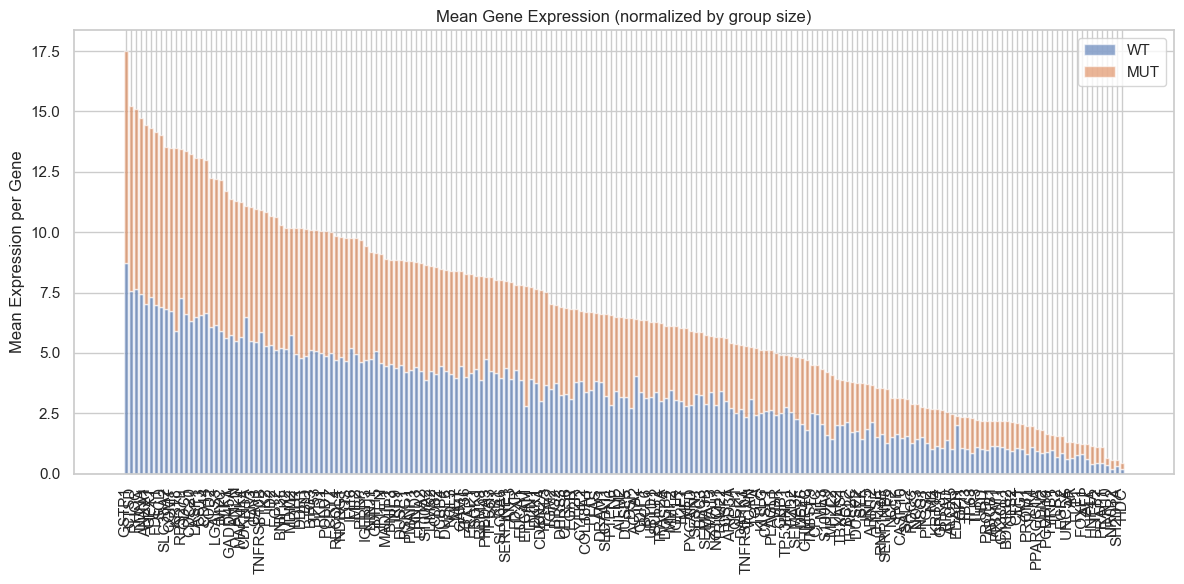

In [191]:
target_genes_check.plot_mean_expression_by_gene(df_tab1_bulk_mut, df_tab1_bulk_wt)

This is just showing that the expression of the targets is higher in the mutated, but it is not saying that our target are better for class prediction than our HVG so it's not that significant

# Network Construction

In [192]:
df_target = pd.read_csv("final_preprocessed_data_target_.csv", index_col=0)
df_target

ENSG00000144452  ENSG00000085563  ENSG00000107796  \
AU565_AAACCAGTTTGG         0.000000              0.0              0.0   
AU565_AAACGTGCAGCG         0.000000              0.0              0.0   
AU565_AAAGCCACATGC         0.000000              0.0              0.0   
AU565_AAAGTCGGCTGG         0.000000              0.0              0.0   
AU565_AAAGTGCCTAAA         0.000000              0.0              0.0   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA         1.002698              0.0              0.0   
ZR751_TTTGGCCGGCAT         0.331385              0.0              0.0   
ZR751_TTTTAGCCGTGA         1.172375              0.0              0.0   
ZR751_TTTTGATATCCG         0.000000              0.0              0.0   
ZR751_TTTTGCACACTA         0.000000              0.0              0.0   

                    ENSG00000181026  ENSG00000081051  ENSG00000042286  \
AU565_AAACCAGTTTGG         0.000000              0.0         0.854990   
AU565_AAACGTGCAGCG         0.000000              0.0         1.176238   
AU565_AAAGCCACATGC         0.000000              0.0         1.397154   
AU565_AAAGTCGGCTGG         0.000000              0.0         0.925356   
AU565_AAAGTGCCTAAA         0.000000              0.0         0.000000   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA         0.000000              0.0         1.493185   
ZR751_TTTGGCCGGCAT         0.331385              0.0         0.331385   
ZR751_TTTTAGCCGTGA         0.000000              0.0         1.172375   
ZR751_TTTTGATATCCG         0.000000              0.0         0.000000   
ZR751_TTTTGCACACTA         0.000000              0.0         0.000000   

                    ENSG00000011426  ENSG00000135046  ENSG00000169083  \
AU565_AAACCAGTTTGG         0.000000              0.0         0.000000   
AU565_AAACGTGCAGCG         0.751924              0.0         0.751924   
AU565_AAAGCCACATGC         0.000000              0.0         0.000000   
AU565_AAAGTCGGCTGG         0.925356              0.0         0.000000   
AU565_AAAGTGCCTAAA         1.241888              0.0         0.000000   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA         0.000000              0.0         1.002698   
ZR751_TTTGGCCGGCAT         0.000000              0.0         0.331385   
ZR751_TTTTAGCCGTGA         0.000000              0.0         0.000000   
ZR751_TTTTGATATCCG         0.000000              0.0         0.838929   
ZR751_TTTTGCACACTA         0.647842              0.0         0.000000   

                    ENSG00000116017  ...  ENSG00000067369  ENSG00000115129  \
AU565_AAACCAGTTTGG         0.000000  ...         0.000000         0.000000   
AU565_AAACGTGCAGCG         0.000000  ...         0.751924         0.000000   
AU565_AAAGCCACATGC         0.000000  ...         0.000000         0.000000   
AU565_AAAGTCGGCTGG         0.000000  ...         0.000000         0.000000   
AU565_AAAGTGCCTAAA         0.000000  ...         0.000000         0.000000   
...                             ...  ...              ...              ...   
ZR751_TTTGGCCCTCGA         0.000000  ...         1.002698         0.000000   
ZR751_TTTGGCCGGCAT         0.000000  ...         0.000000         0.331385   
ZR751_TTTTAGCCGTGA         0.000000  ...         0.000000         0.000000   
ZR751_TTTTGATATCCG         0.838929  ...         1.288620         0.838929   
ZR751_TTTTGCACACTA         0.647842  ...         1.037737         0.647842   

                    ENSG00000164938  ENSG00000132274  ENSG00000177169  \
AU565_AAACCAGTTTGG              0.0              0.0         0.000000   
AU565_AAACGTGCAGCG              0.0              0.0         0.000000   
AU565_AAAGCCACATGC              0.0              0.0         0.000000   
AU565_AAAGTCGGCTGG              0.0              0.0         0.000000   
AU565_AAAGTGCCTAAA              0.0              0.0         0.000000   
...           

In [193]:
df = pd.read_csv("final_preprocessed_data_HVG_.csv", index_col=0)
df

ENSG00000001084  ENSG00000001461  ENSG00000002834  \
AU565_AAACCAGTTTGG              0.0         0.000000              0.0   
AU565_AAACGTGCAGCG              0.0         0.000000              0.0   
AU565_AAAGCCACATGC              0.0         0.000000              0.0   
AU565_AAAGTCGGCTGG              0.0         0.000000              0.0   
AU565_AAAGTGCCTAAA              0.0         0.802482              0.0   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA              0.0         0.000000              0.0   
ZR751_TTTGGCCGGCAT              0.0         0.331385              0.0   
ZR751_TTTTAGCCGTGA              0.0         0.748973              0.0   
ZR751_TTTTGATATCCG              0.0         0.000000              0.0   
ZR751_TTTTGCACACTA              0.0         0.000000              0.0   

                    ENSG00000005884  ENSG00000006282  ENSG00000006459  \
AU565_AAACCAGTTTGG              0.0         0.000000         0.000000   
AU565_AAACGTGCAGCG              0.0         0.751924         0.000000   
AU565_AAAGCCACATGC              0.0         0.000000         0.000000   
AU565_AAAGTCGGCTGG              0.0         0.000000         0.925356   
AU565_AAAGTGCCTAAA              0.0         0.000000         0.000000   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA              0.0         0.000000         1.002698   
ZR751_TTTGGCCGGCAT              0.0         0.331385         0.000000   
ZR751_TTTTAGCCGTGA              0.0         0.748973         0.000000   
ZR751_TTTTGATATCCG              0.0         0.838929         0.000000   
ZR751_TTTTGCACACTA              0.0         0.000000         0.000000   

                    ENSG00000006757  ENSG00000007944  ENSG00000008283  \
AU565_AAACCAGTTTGG         0.000000         0.000000         0.000000   
AU565_AAACGTGCAGCG         0.751924         0.751924         0.751924   
AU565_AAAGCCACATGC         0.000000         0.000000         0.000000   
AU565_AAAGTCGGCTGG         0.000000         0.000000         0.925356   
AU565_AAAGTGCCTAAA         0.000000         0.000000         1.546118   
...                             ...              ...              ...   
ZR751_TTTGGCCCTCGA         0.000000         0.000000         1.002698   
ZR751_TTTGGCCGGCAT         0.778723         0.000000         0.000000   
ZR751_TTTTAGCCGTGA         1.172375         0.000000         0.748973   
ZR751_TTTTGATATCCG         0.000000         0.000000         0.000000   
ZR751_TTTTGCACACTA         0.000000         0.647842         1.535930   

                    ENSG00000008838  ...  ENSG00000104371  ENSG00000188257  \
AU565_AAACCAGTTTGG              0.0  ...              0.0              0.0   
AU565_AAACGTGCAGCG              0.0  ...              0.0              0.0   
AU565_AAAGCCACATGC              0.0  ...              0.0              0.0   
AU565_AAAGTCGGCTGG              0.0  ...              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0  ...              0.0              0.0   
...                             ...  ...              ...              ...   
ZR751_TTTGGCCCTCGA              0.0  ...              0.0              0.0   
ZR751_TTTGGCCGGCAT              0.0  ...              0.0              0.0   
ZR751_TTTTAGCCGTGA              0.0  ...              0.0              0.0   
ZR751_TTTTGATATCCG              0.0  ...              0.0              0.0   
ZR751_TTTTGCACACTA              0.0  ...              0.0              0.0   

                    ENSG00000108700  ENSG00000167656  ENSG00000167779  \
AU565_AAACCAGTTTGG              0.0         0.000000              0.0   
AU565_AAACGTGCAGCG              0.0         0.000000              0.0   
AU565_AAAGCCACATGC              0.0         0.924988              0.0   
AU565_AAAGTCGGCTGG              0.0         0.000000              0.0   
AU565_AAAGTGCCTAAA              0.0         0.000000              0.0   
...           

In [194]:
#Split in train and test set
train_df, test_df = network_constructor.train_test_split(df, test_size=0.2, random_state=42)
print(f"shape del train test: {train_df.shape} \nshape del test set: {test_df.shape}")

shape del train test: (24571, 2071) 
shape del test set: (6143, 2071)


Percentage of non-zero values in the correlation matrix: 0.025490909939555183


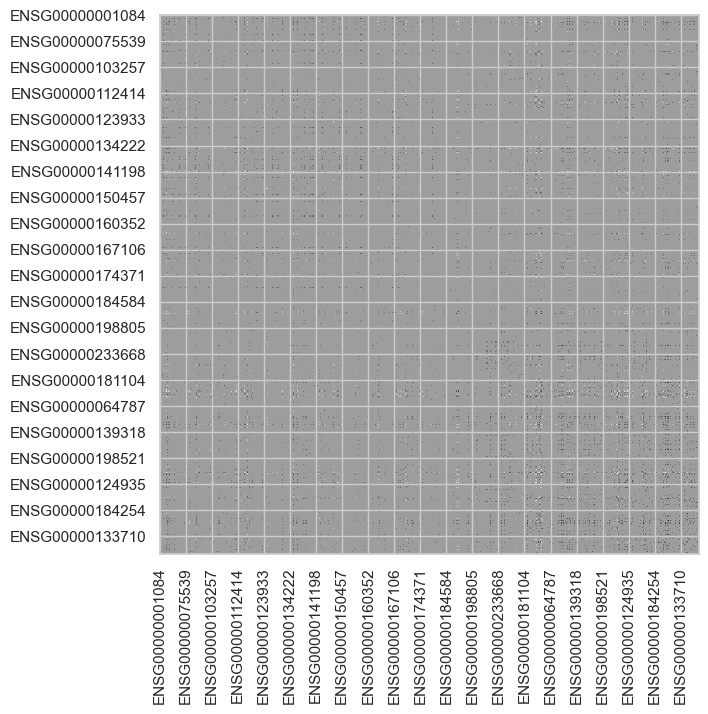

In [195]:
#Construction of the correlation matrix
mat=network_constructor.build_correlation_matrix(train_df.iloc[:,:-1], corr_threshold=0.2, p_value_threshold=0.05) 
network_constructor.check_percentage_of_zeros(mat)
network_constructor.plot_the_correlation_matrix(train_df, mat)

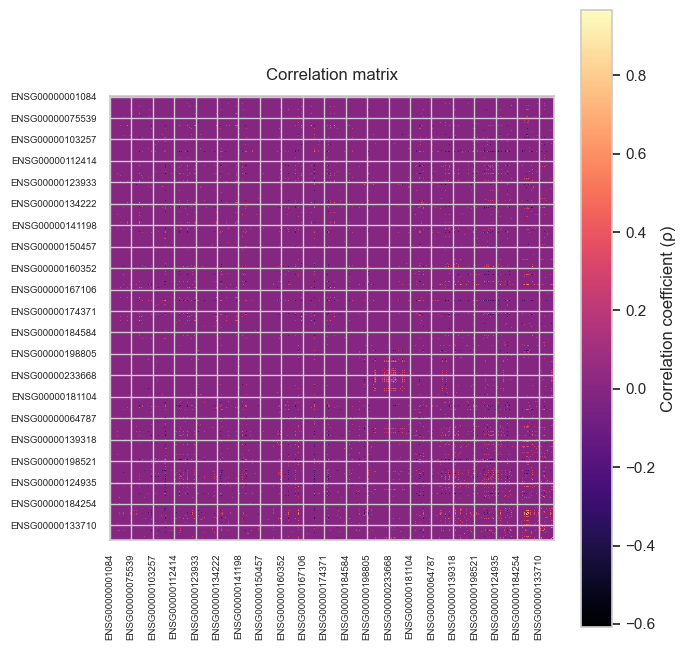

In [205]:
network_constructor.plot_the_correlation_matrix_colored(train_df.iloc[:,:-1],mat)

In [ ]:
# #GRAPH CONSTRUCTION, WE DO IT ON THE CLUSTER, HERE WE ONLY DO 50 FOR TESTING

# train_df_pyg = network_constructor.create_PyG_graph_from_df(train_df[:50], mat, label_column="mutation_status")
# test_df_pyg = network_constructor.create_PyG_graph_from_df(test_df[:20], mat, label_column="mutation_status")

# #check
# print(f"First element of train_df_pyg: {train_df_pyg[0]}")
# print(f"First element of test_df_pyg: {test_df_pyg[0]}")
# assert network_constructor.check_graph_structure(train_df_pyg), "The graphs in the train set do not have the same structure."
# assert network_constructor.check_graph_structure(test_df_pyg), "The graphs in the test set do not have the same structure."

In [207]:
#LOAD THE GRAPHS OBTAINED ON THE CLUSTER
first_train_batch = torch.load("../data/graphs_baseline_HVG/train/batch_000.pt", weights_only=False)
first_test_batch = torch.load("../data/graphs_baseline_HVG/test/batch_000.pt", weights_only=False)

#check
print(f"First element of train_df_pyg: {first_train_batch[0]}")
print(f"First element of test_df_pyg: {first_test_batch[0]}")
assert network_constructor.check_graph_structure(first_train_batch), "The graphs in the train set do not have the same structure."
assert network_constructor.check_graph_structure(first_test_batch), "The graphs in the test set do not have the same structure."

First element of train_df_pyg: Data(x=[3808, 1], edge_index=[2, 157158], y=[1])
First element of test_df_pyg: Data(x=[3808, 1], edge_index=[2, 157158], y=[1])


Number of nodes: 3808
Number of edges: 157158
NUmber of features per node: 1
Has isolated nodes: True
Has self-loops: False
Is undirected: True


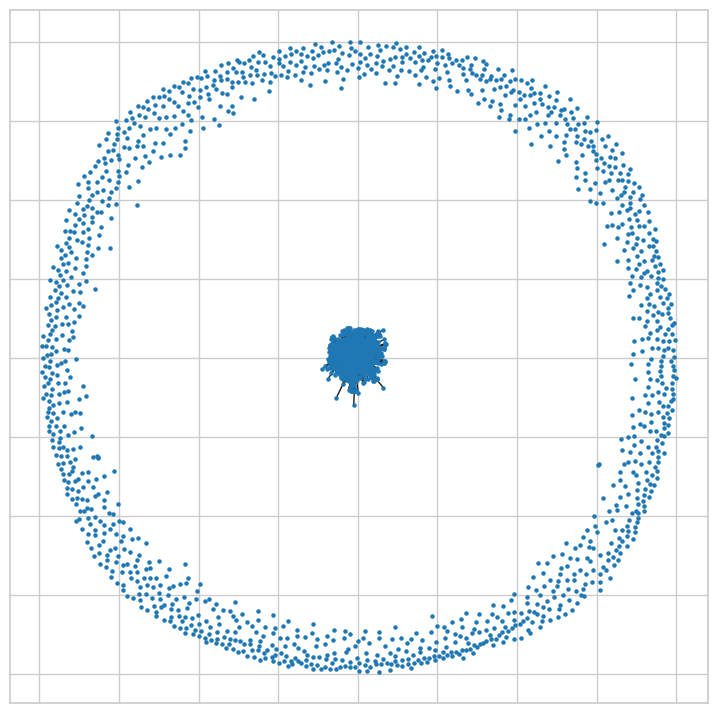

In [208]:
network_constructor.get_info_and_plot_graph(first_train_batch)

Number of nodes: 138
Number of edges: 846
NUmber of features per node: 1
Has isolated nodes: True
Has self-loops: False
Is undirected: True


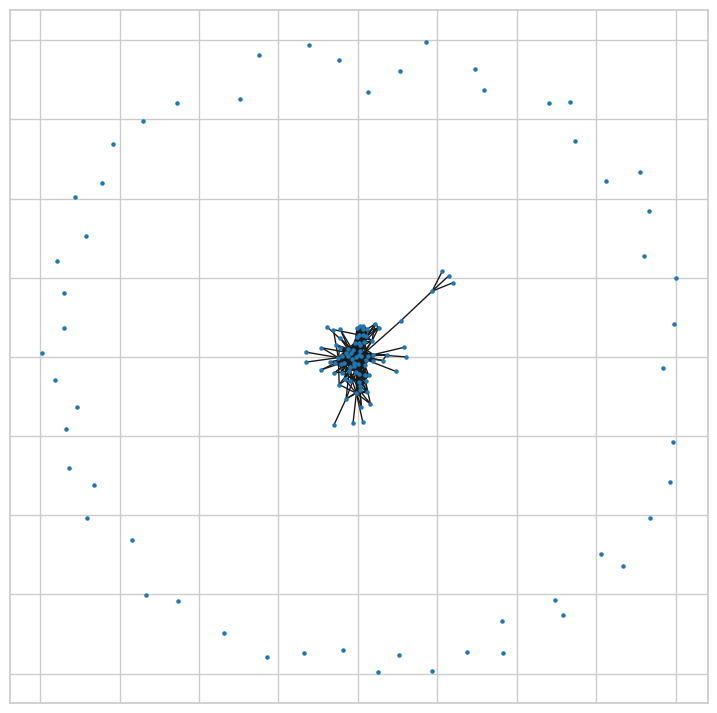

In [209]:
first_train_batch_target = torch.load("../data/graphs_baseline_target/train/batch_000.pt", weights_only=False)
network_constructor.get_info_and_plot_graph(first_train_batch_target)

# Model comparison

## HVG

### HVG - GCN

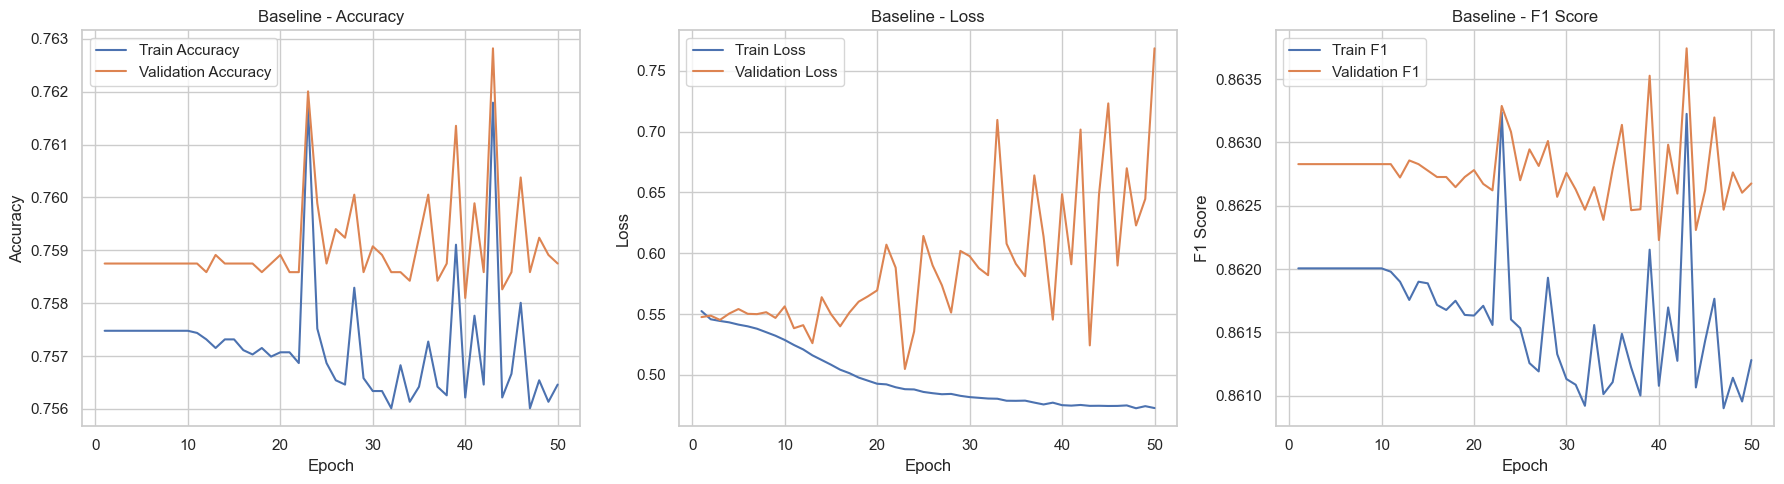

In [210]:
model_comparison.plot_training_curves("../Results/HVG/gcn_results/Baseline/training_log.csv", model_name= "Baseline")

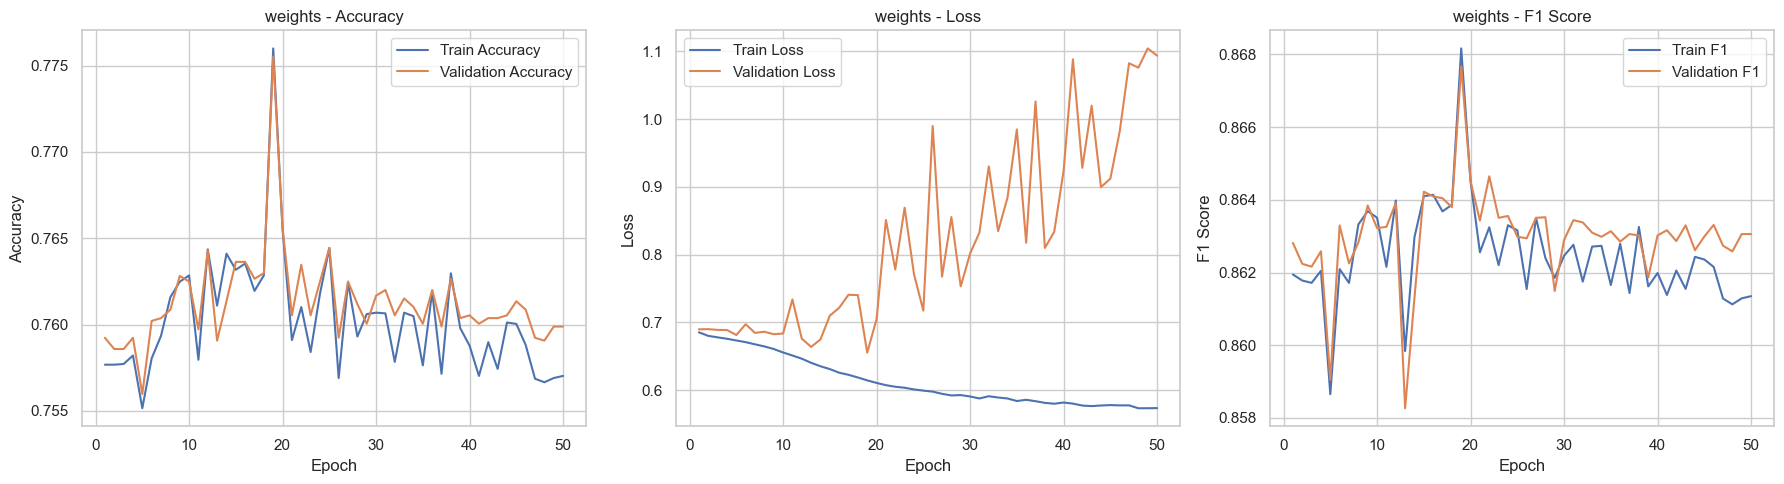

In [211]:
model_comparison.plot_training_curves("../Results/HVG/gcn_results/weight/training_log.csv", model_name = "weights")

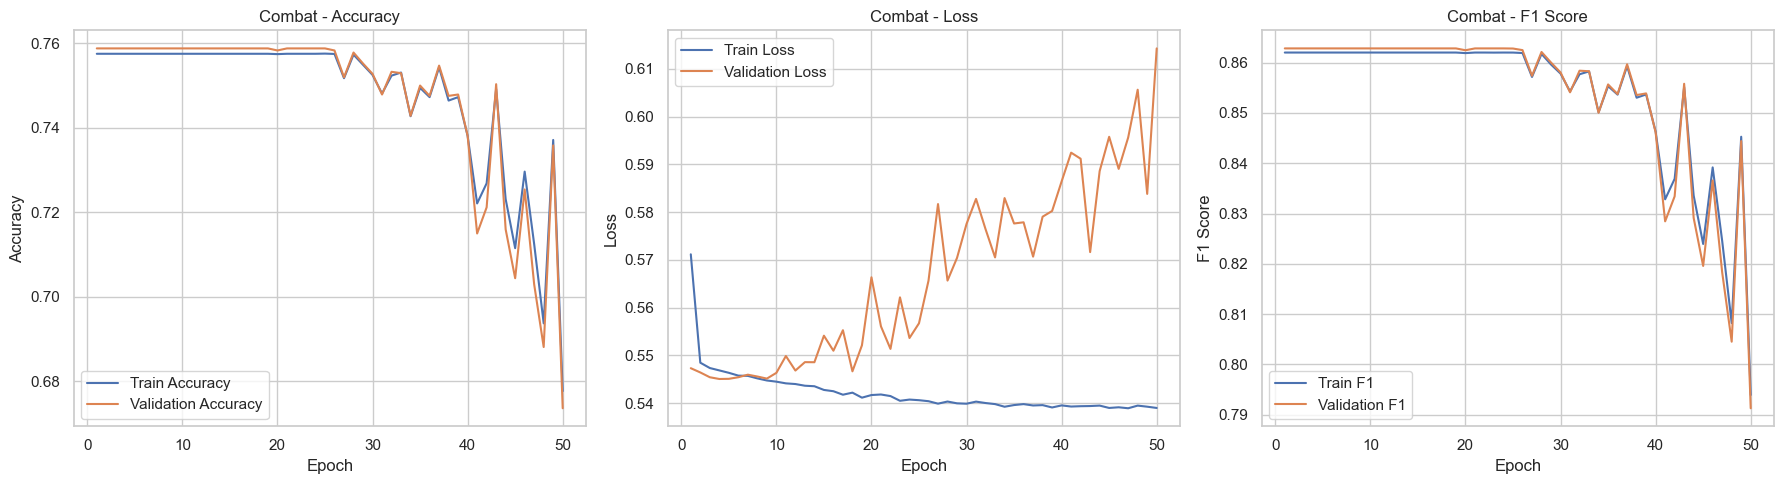

In [212]:
model_comparison.plot_training_curves("../Results/HVG/gcn_results/Combat/training_log.csv", model_name = "Combat")

/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 2070 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


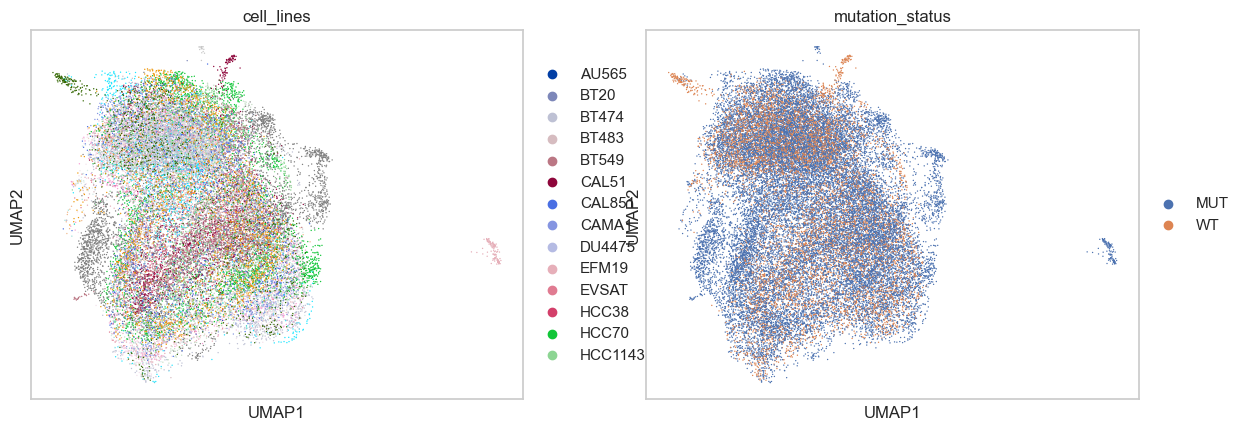

In [213]:
df_temp=pd.read_csv("../notebooks/final_preprocessed_data_HVG_combat.csv",index_col=0)
feature_cols = df_temp.columns[:-1]
mut_status = df_temp.columns[-1]
adata_batch = ad.AnnData(X=df_temp[feature_cols].values)
adata_batch.obs_names = df_temp.index
adata_batch.var_names = feature_cols
adata_batch.obs[mut_status] = df_temp[mut_status].values
adata_batch.obs["cell_lines"] = adata_batch.obs_names.str.split("_").str[0]
sc.pp.neighbors(adata_batch)
sc.tl.umap(adata_batch)
sc.pl.umap(adata_batch, color = ["cell_lines","mutation_status"])


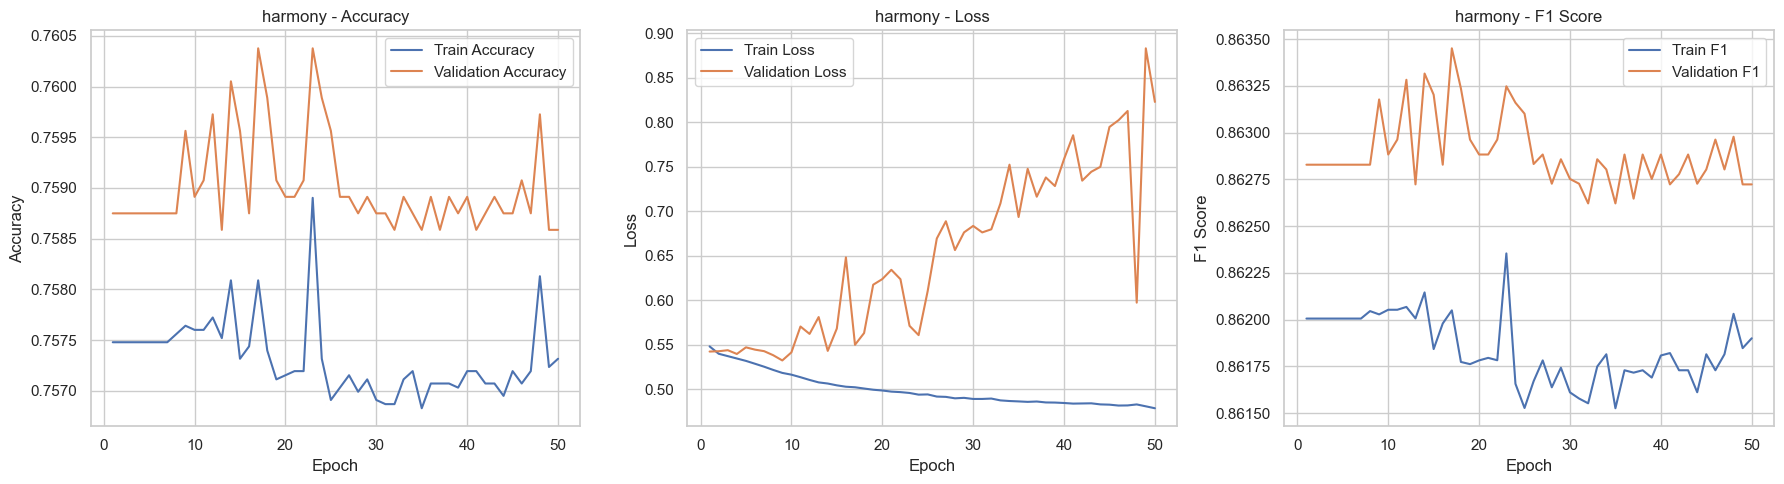

In [214]:
model_comparison.plot_training_curves("../Results/HVG/gcn_results/harmony/training_log.csv", model_name = "harmony")

/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 2070 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


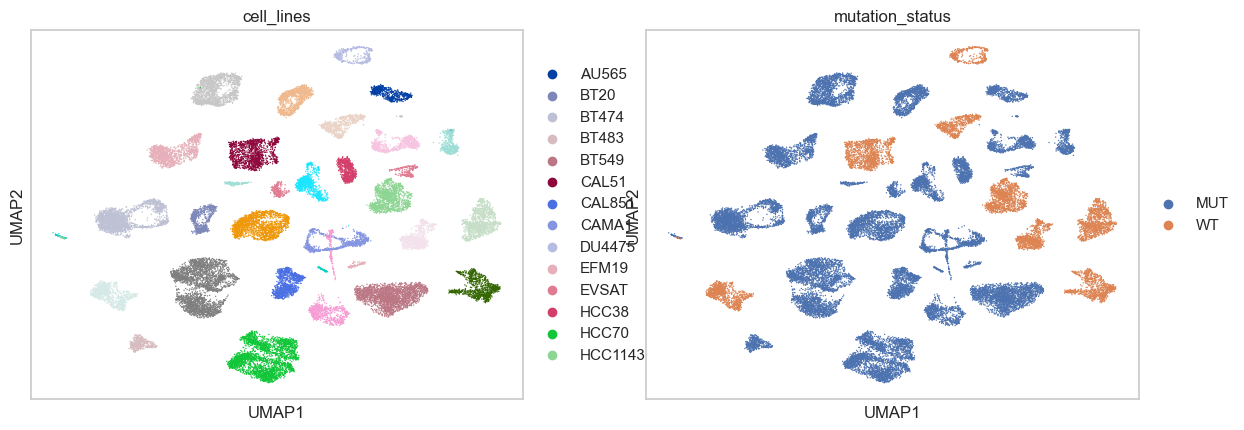

In [215]:
df_temp=pd.read_csv("../notebooks/final_preprocessed_data_HVG_harmony.csv",index_col=0)
feature_cols = df_temp.columns[:-1]
mut_status = df_temp.columns[-1]
adata_batch = ad.AnnData(X=df_temp[feature_cols].values)
adata_batch.obs_names = df_temp.index
adata_batch.var_names = feature_cols
adata_batch.obs[mut_status] = df_temp[mut_status].values
adata_batch.obs["cell_lines"] = adata_batch.obs_names.str.split("_").str[0]
sc.pp.neighbors(adata_batch)
sc.tl.umap(adata_batch)
sc.pl.umap(adata_batch, color = ["cell_lines","mutation_status"])

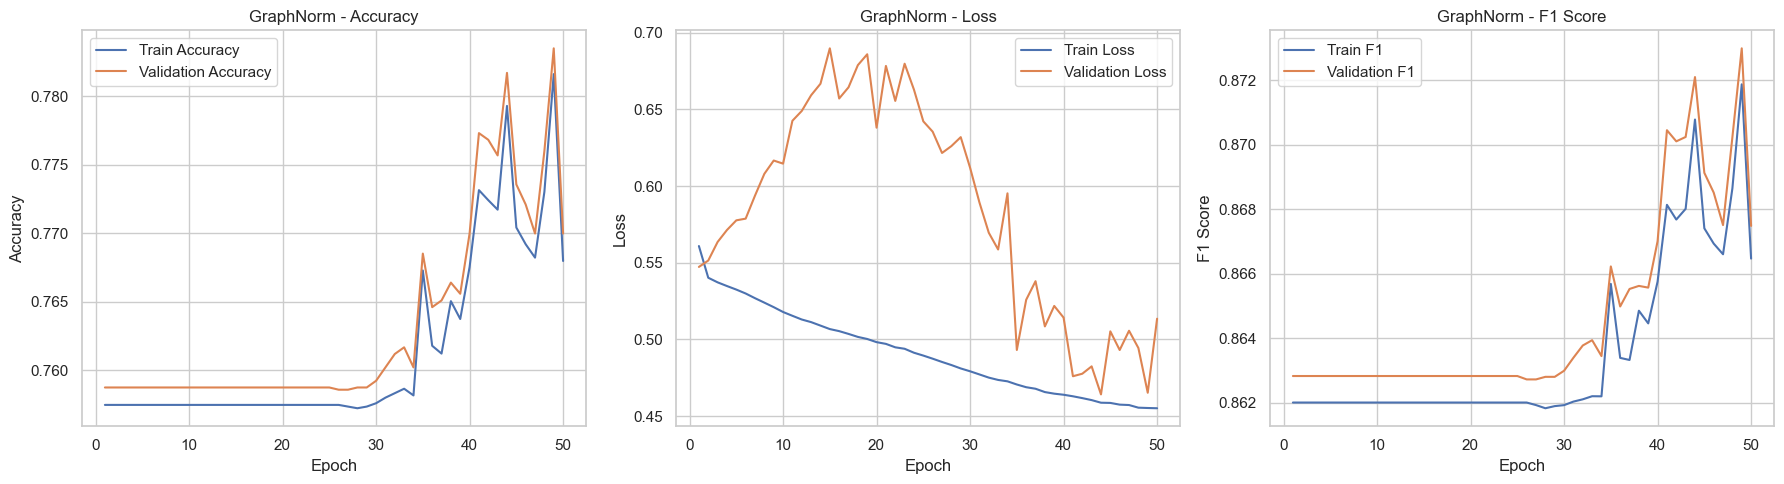

In [216]:
model_comparison.plot_training_curves("../Results/HVG/gcn_results/GraphNorm/training_log.csv",model_name="GraphNorm")

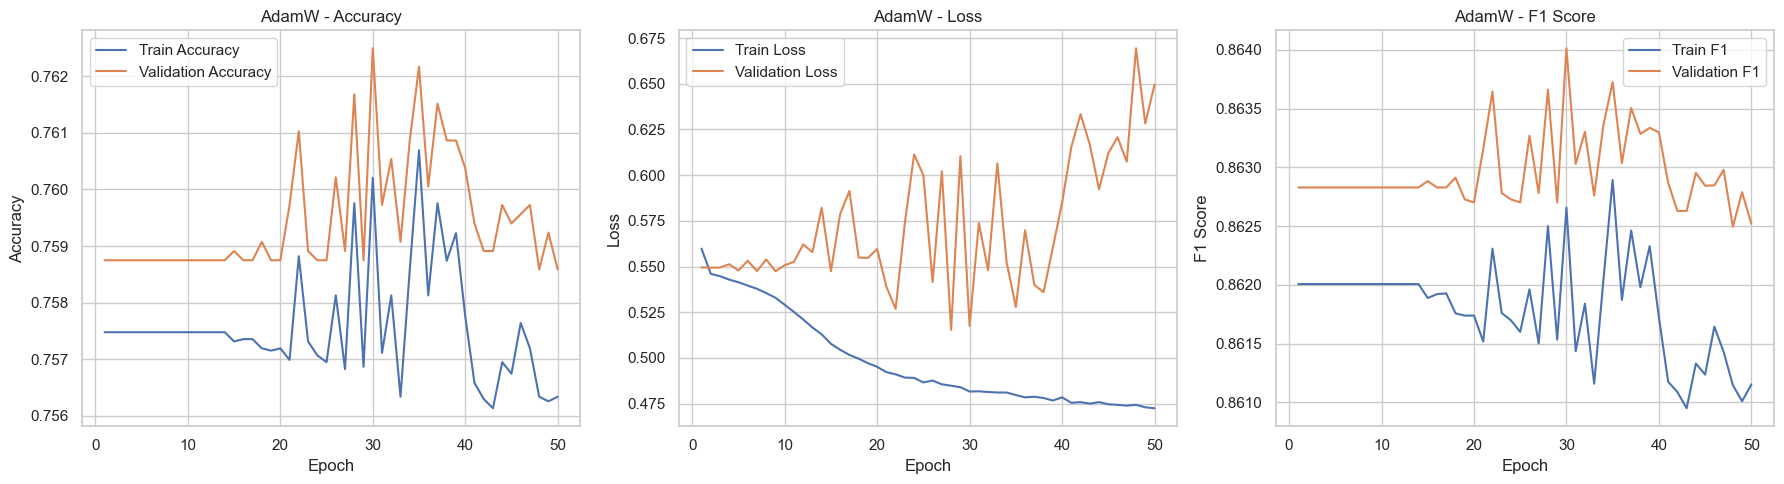

In [217]:
model_comparison.plot_training_curves("../Results/HVG/gcn_results/AdamW/training_log.csv",model_name="AdamW")

### HVG - GAT

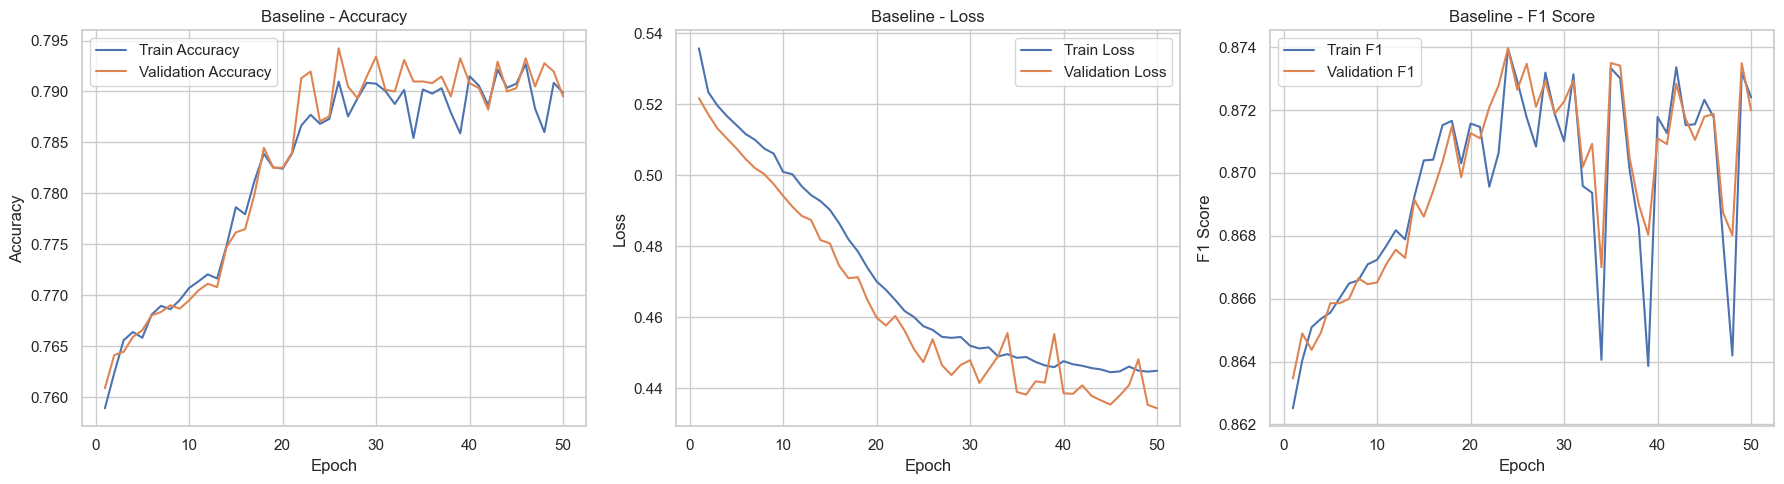

In [218]:
model_comparison.plot_training_curves("../Results/HVG/gat_results/Baseline/training_log.csv", model_name= "Baseline")

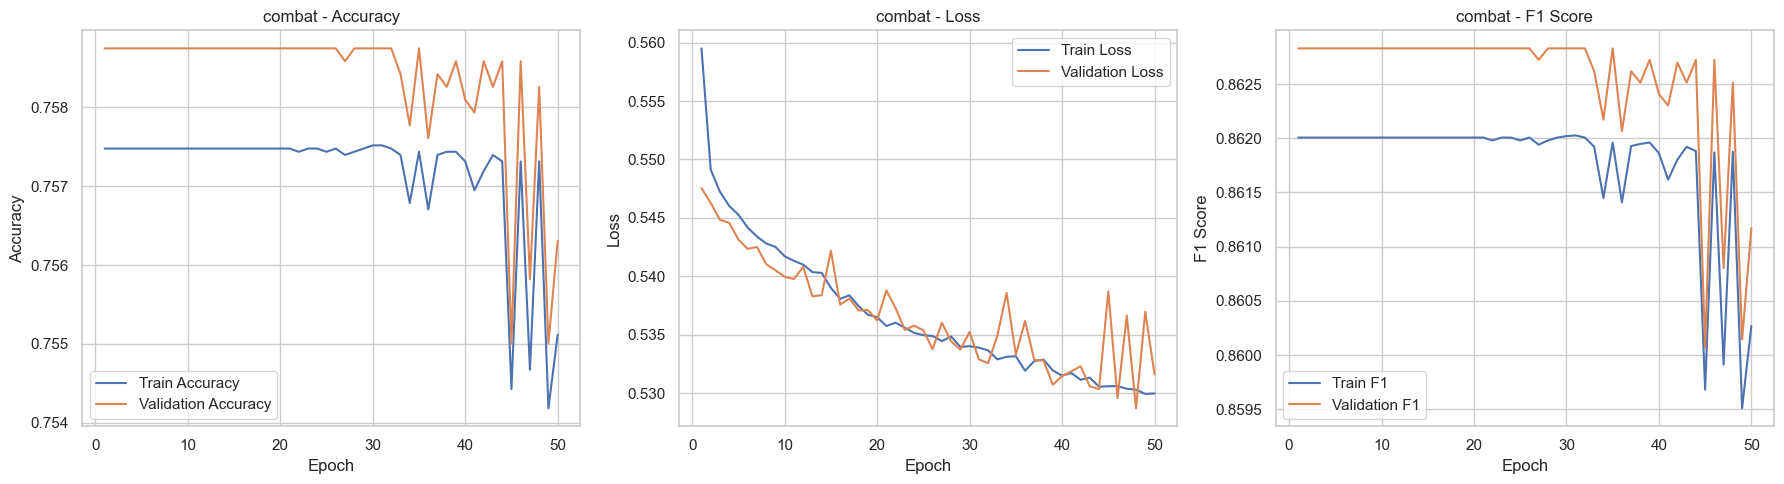

In [219]:
model_comparison.plot_training_curves("../Results/HVG/gat_results/combat/training_log.csv", model_name= "combat")

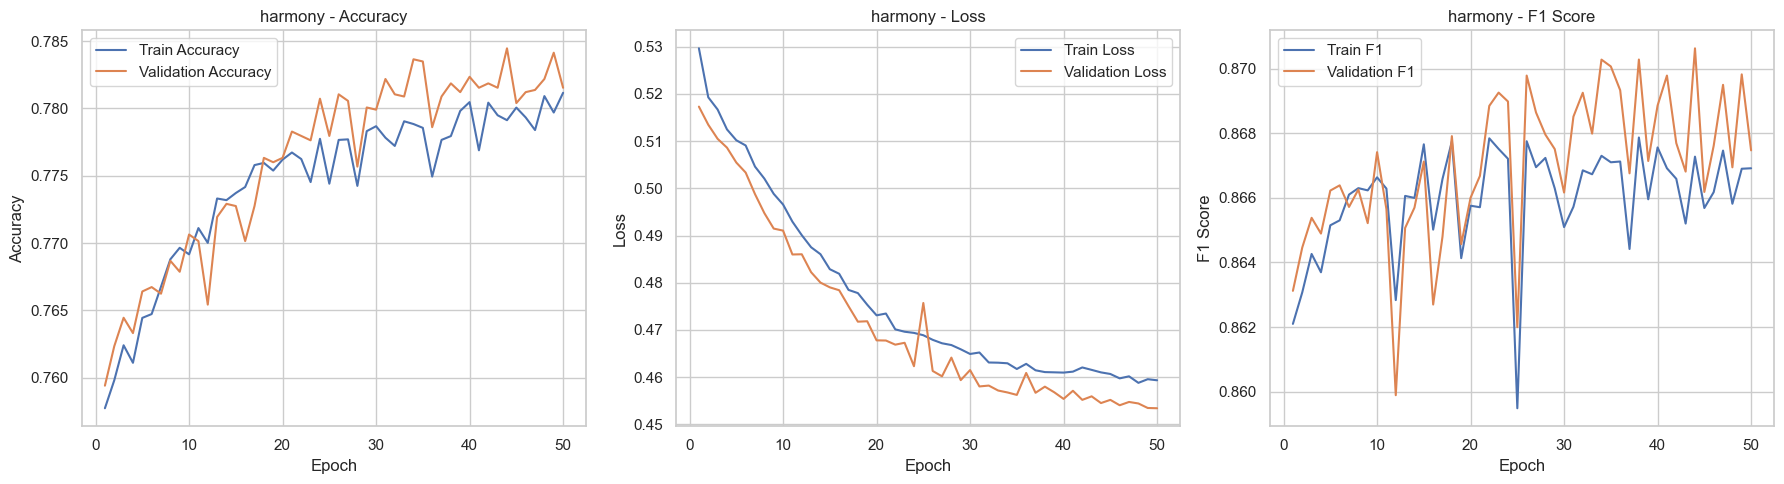

In [220]:
model_comparison.plot_training_curves("../Results/HVG/gat_results/harmony/training_log.csv", model_name= "harmony")

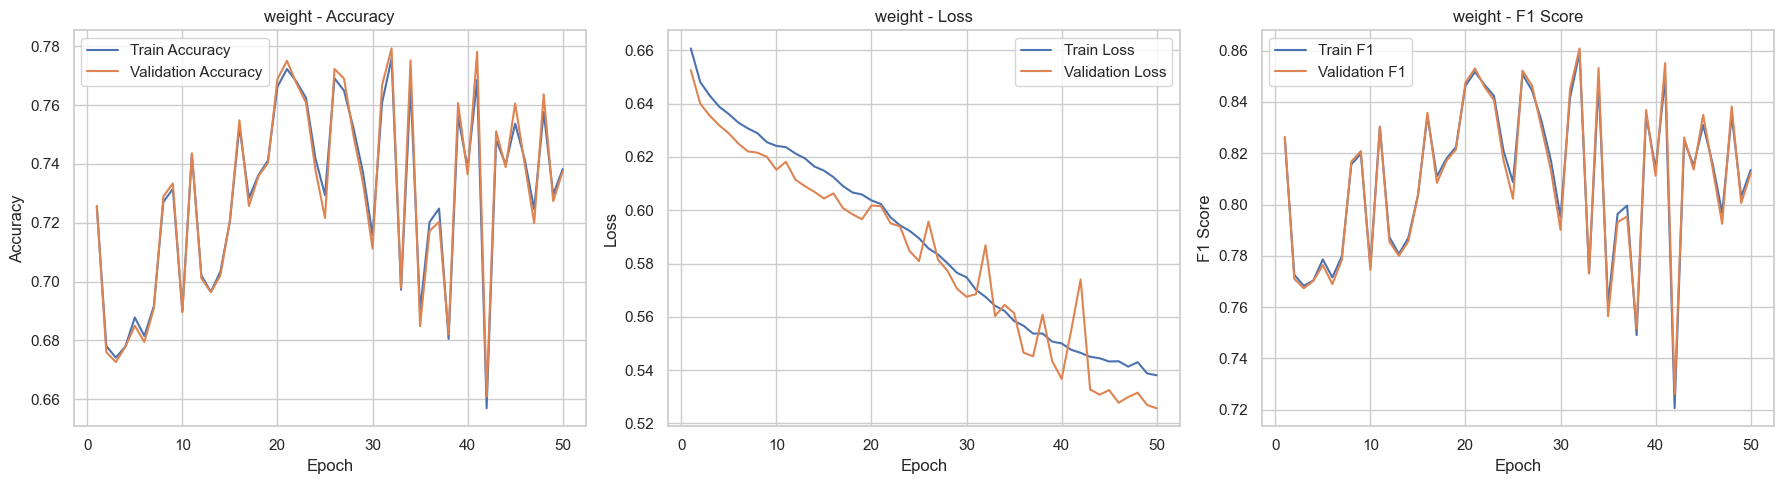

In [221]:
model_comparison.plot_training_curves("../Results/HVG/gat_results/weight/training_log.csv", model_name= "weight")

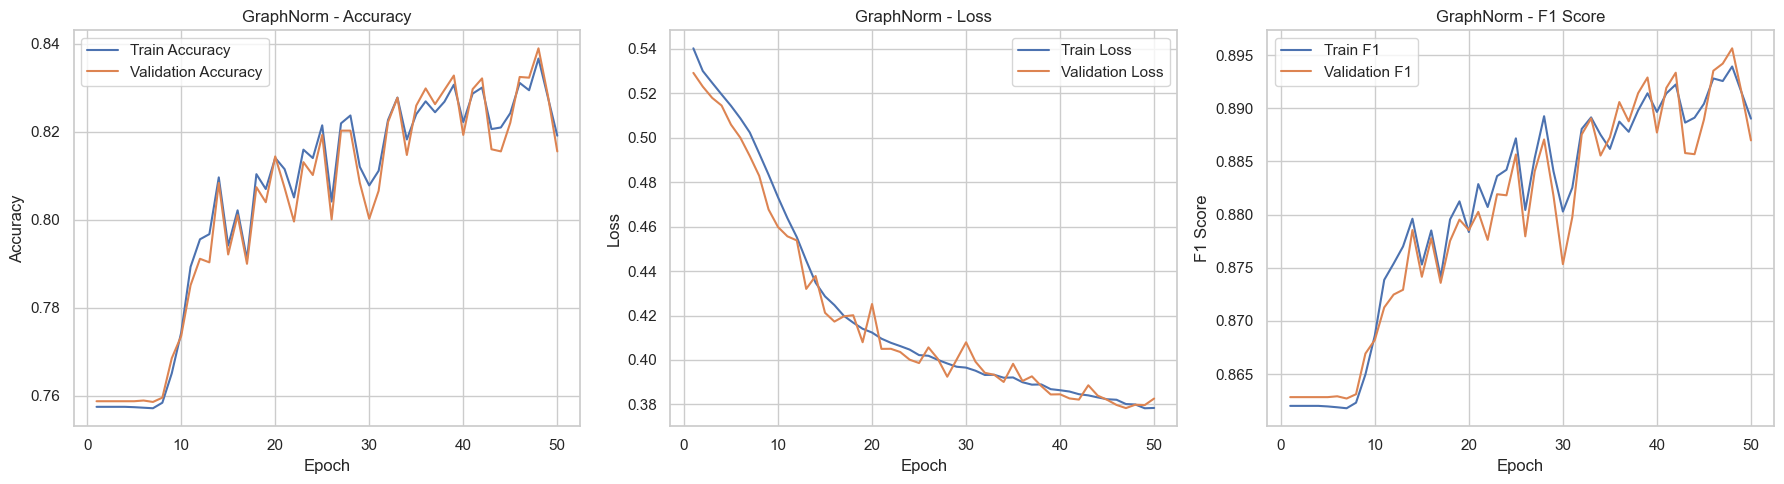

In [222]:
model_comparison.plot_training_curves("../Results/HVG/gat_results/GraphNorm/training_log.csv", model_name= "GraphNorm")

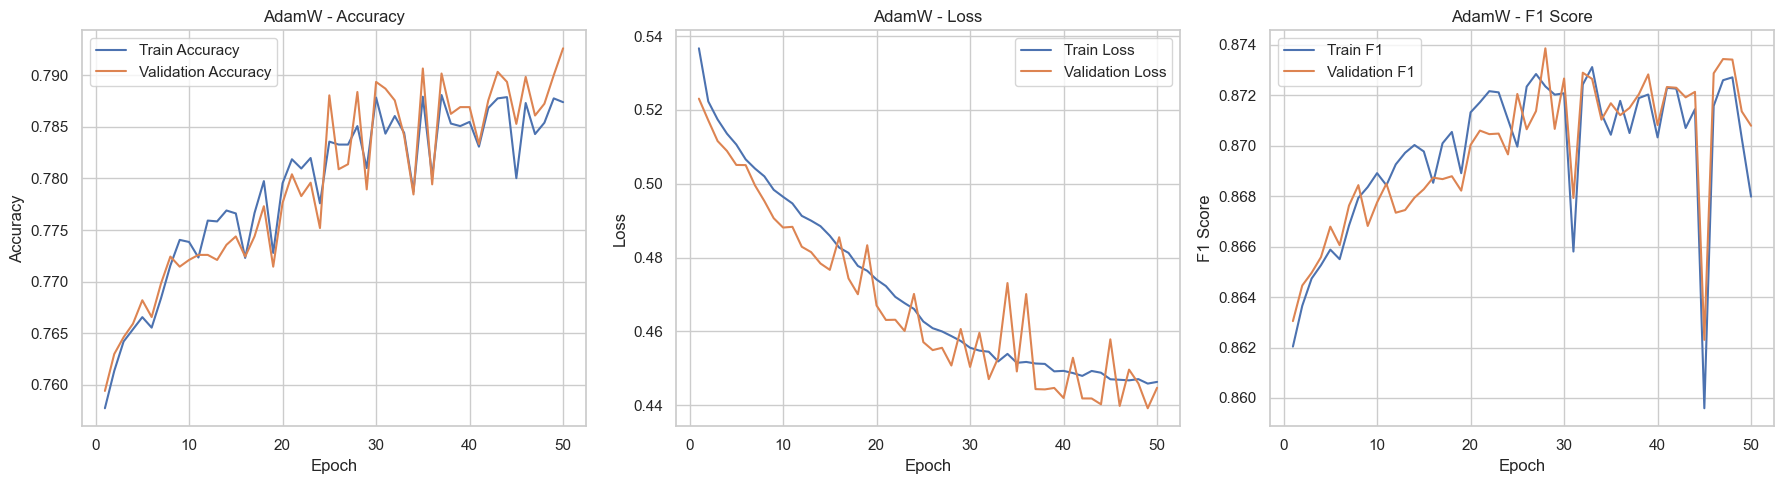

In [223]:
model_comparison.plot_training_curves("../Results/HVG/gat_results/AdamW/training_log.csv", model_name= "AdamW")

### HVG - Fine tuned model

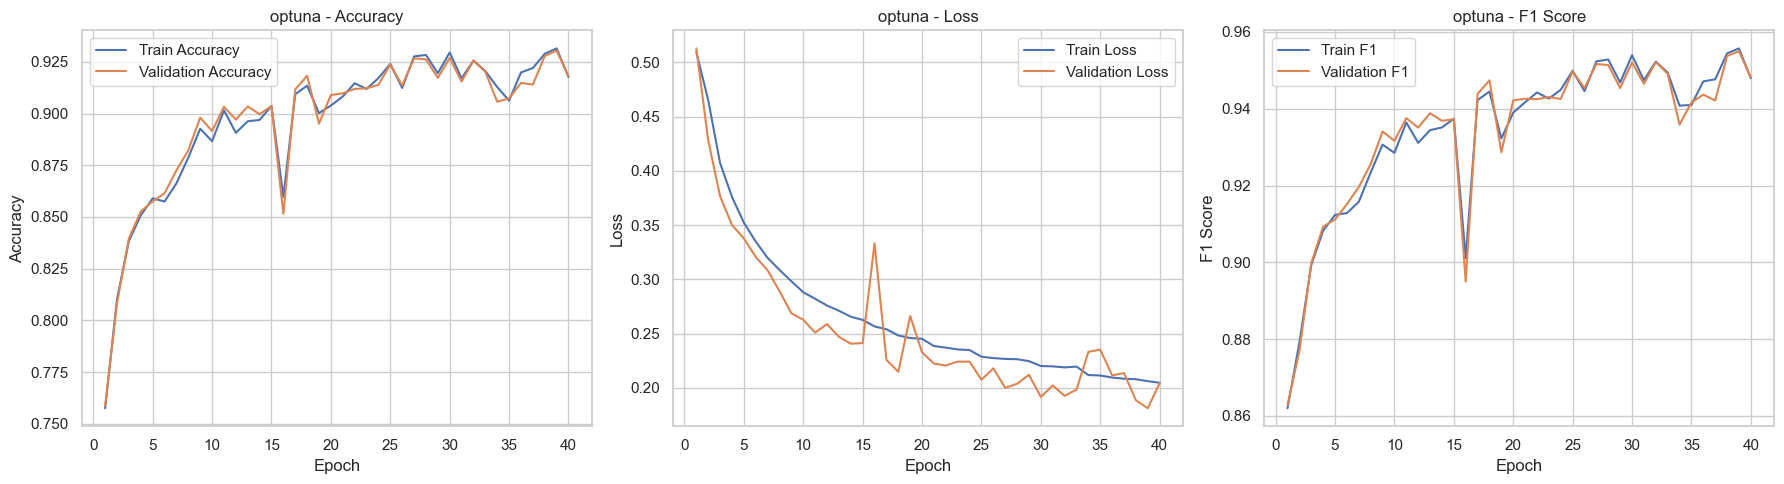

In [224]:
model_comparison.plot_training_curves("../Results/HVG/gat_results/optuna_15/training_log.csv", model_name = "optuna")

## TP53 Target

### Tp53 Target - GCN

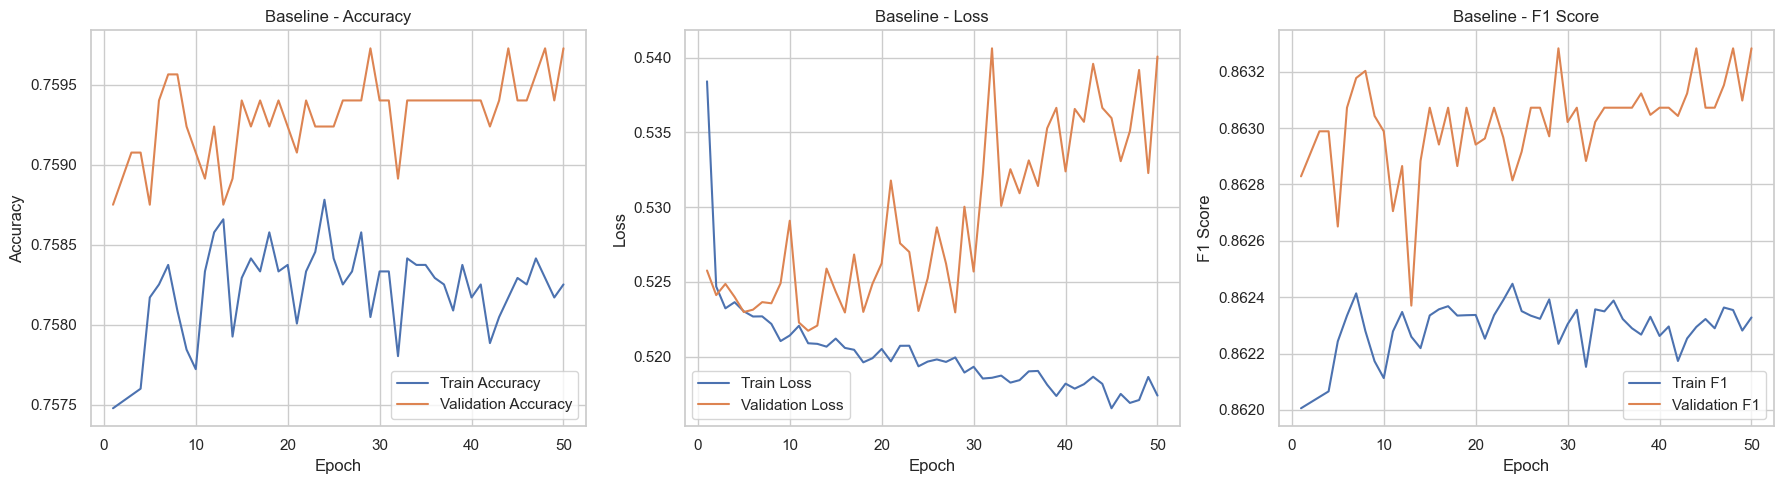

In [225]:
model_comparison.plot_training_curves("../Results/target/gcn_results/Baseline/training_log.csv", model_name= "Baseline")

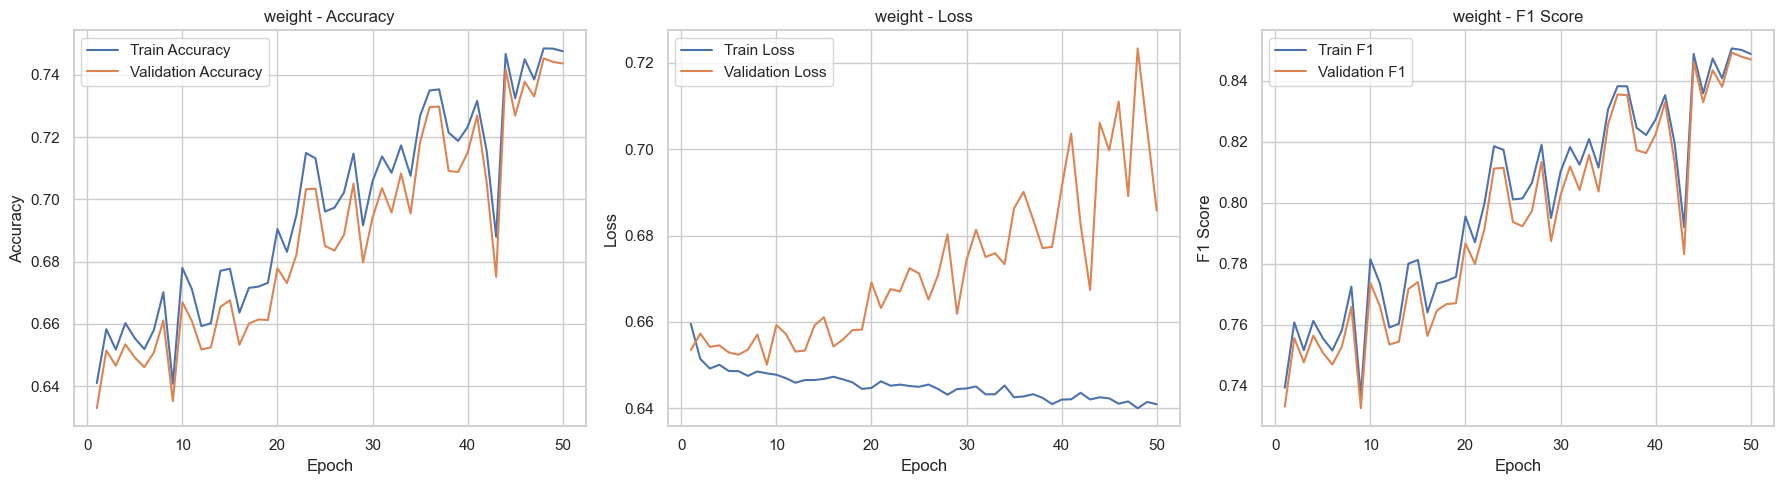

In [226]:
model_comparison.plot_training_curves("../Results/target/gcn_results/weight/training_log.csv", model_name= "weight")

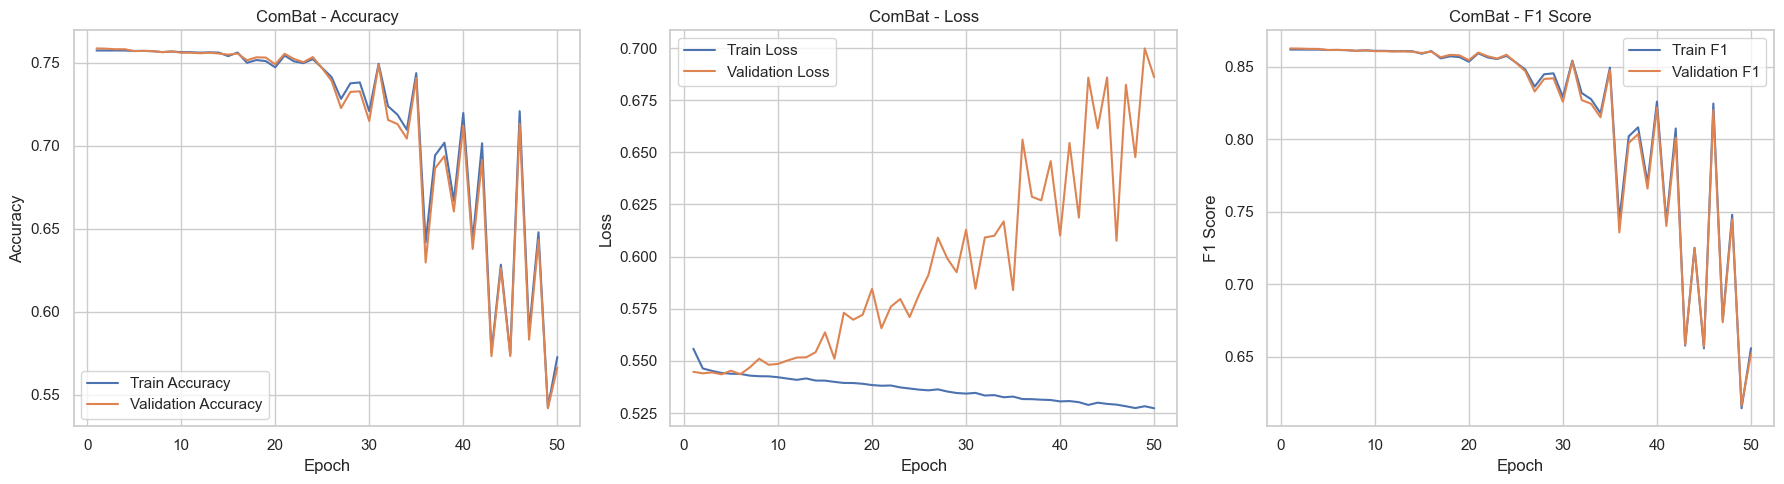

In [227]:
model_comparison.plot_training_curves("../Results/target/gcn_results/combat/training_log.csv", model_name= "ComBat")

/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 138 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


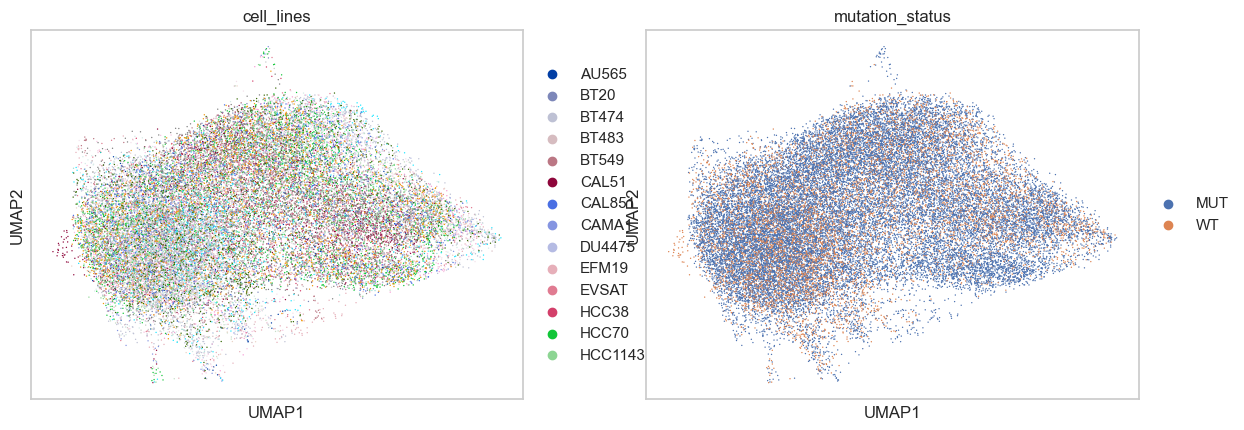

In [228]:
df_temp=pd.read_csv("../notebooks/final_preprocessed_data_target_combat.csv",index_col=0)
feature_cols = df_temp.columns[:-1]
mut_status = df_temp.columns[-1]
adata_batch = ad.AnnData(X=df_temp[feature_cols].values)
adata_batch.obs_names = df_temp.index
adata_batch.var_names = feature_cols
adata_batch.obs[mut_status] = df_temp[mut_status].values
adata_batch.obs["cell_lines"] = adata_batch.obs_names.str.split("_").str[0]
sc.pp.neighbors(adata_batch)
sc.tl.umap(adata_batch)
sc.pl.umap(adata_batch, color = ["cell_lines","mutation_status"])

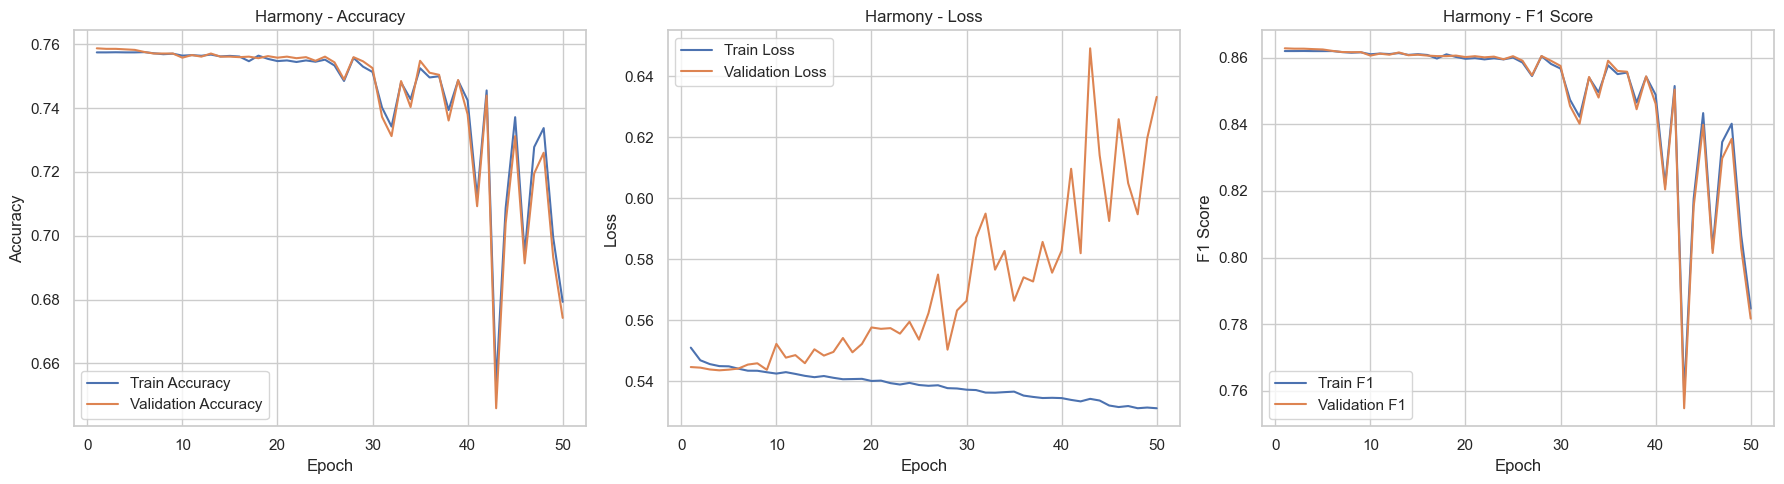

In [229]:
model_comparison.plot_training_curves("../Results/target/gcn_results/harmony/training_log.csv", model_name= "Harmony")

/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 138 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


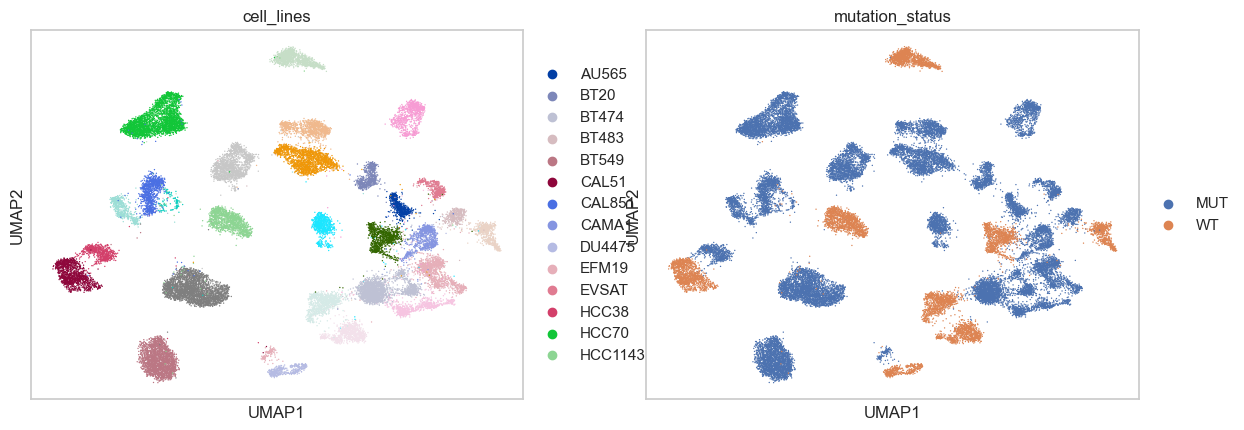

In [230]:
df_temp=pd.read_csv("../notebooks/final_preprocessed_data_target_harmony.csv",index_col=0)
feature_cols = df_temp.columns[:-1]
mut_status = df_temp.columns[-1]
adata_batch = ad.AnnData(X=df_temp[feature_cols].values)
adata_batch.obs_names = df_temp.index
adata_batch.var_names = feature_cols
adata_batch.obs[mut_status] = df_temp[mut_status].values
adata_batch.obs["cell_lines"] = adata_batch.obs_names.str.split("_").str[0]
sc.pp.neighbors(adata_batch)
sc.tl.umap(adata_batch)
sc.pl.umap(adata_batch, color = ["cell_lines","mutation_status"])

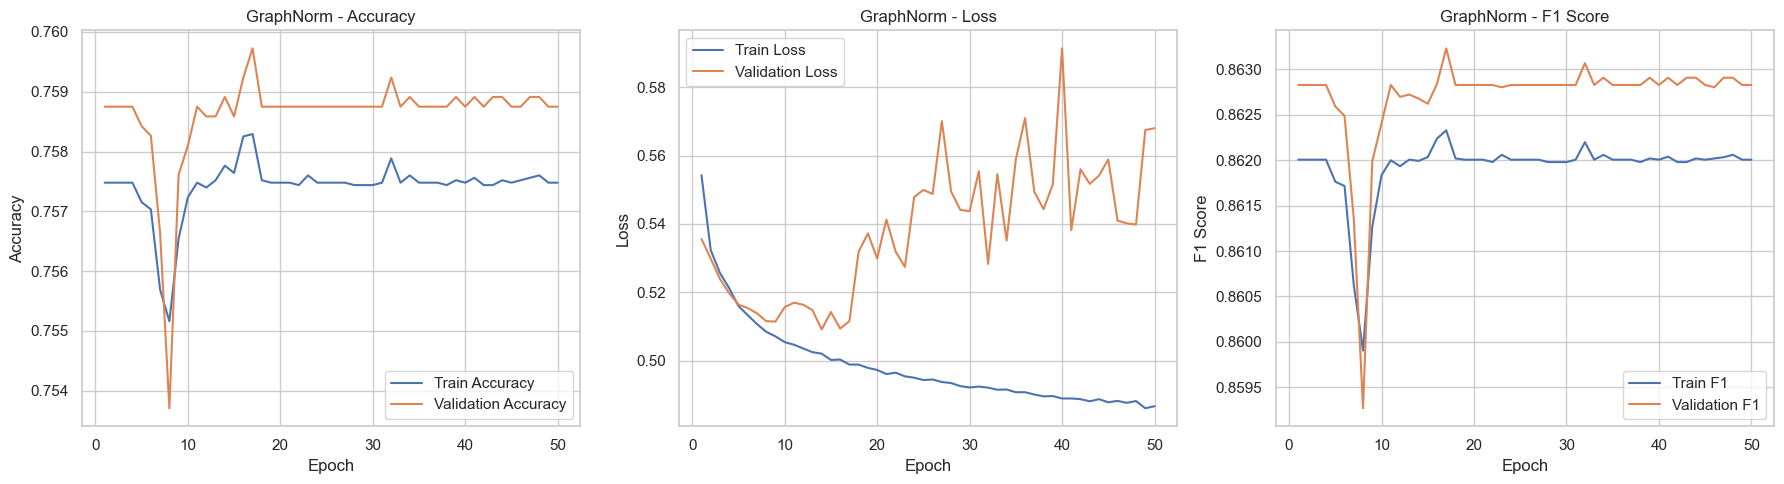

In [231]:
model_comparison.plot_training_curves("../Results/target/gcn_results/GraphNorm/training_log.csv", model_name= "GraphNorm")

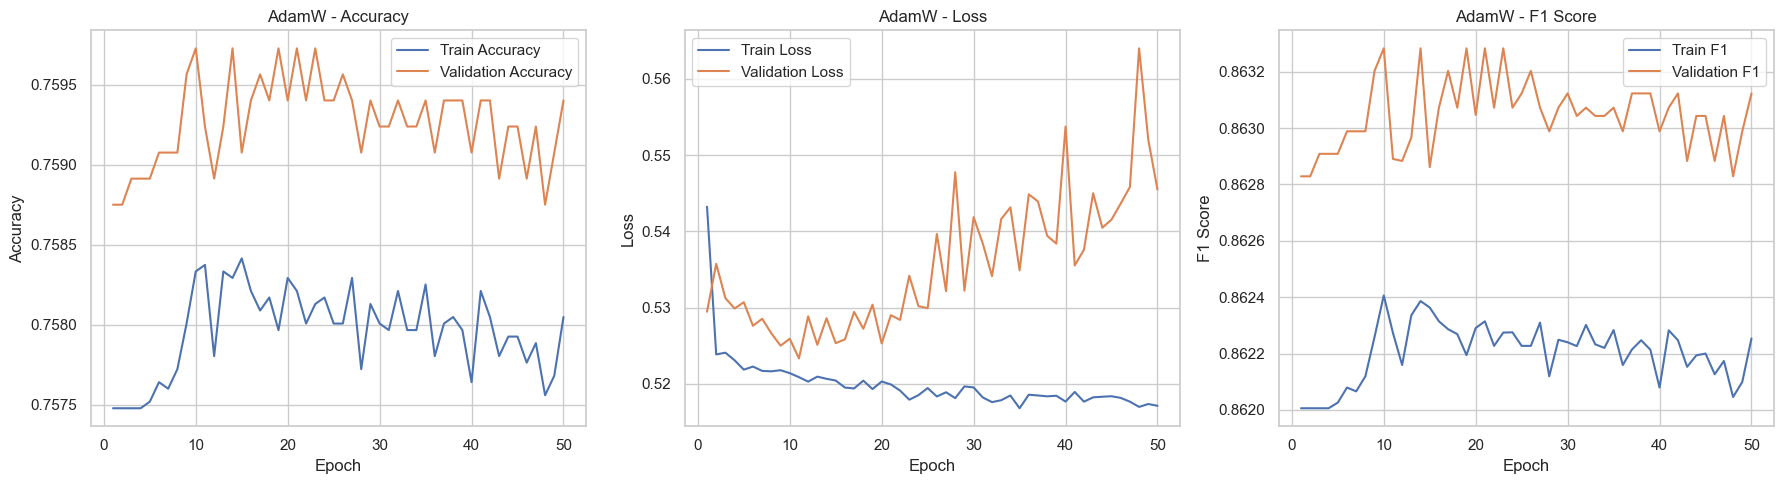

In [232]:
model_comparison.plot_training_curves("../Results/target/gcn_results/AdamW/training_log.csv", model_name= "AdamW")

### Tp53 Target - GAT

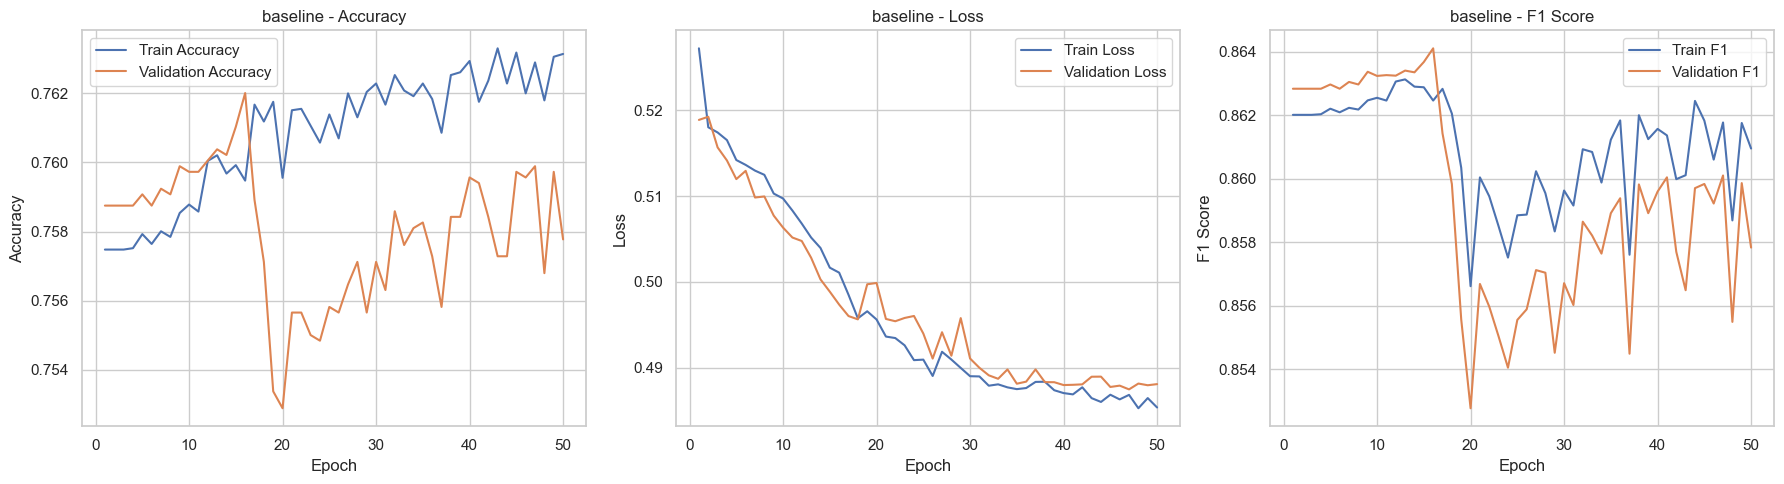

In [233]:
model_comparison.plot_training_curves("../Results/target/gat_results/baseline/training_log.csv", model_name= "baseline")

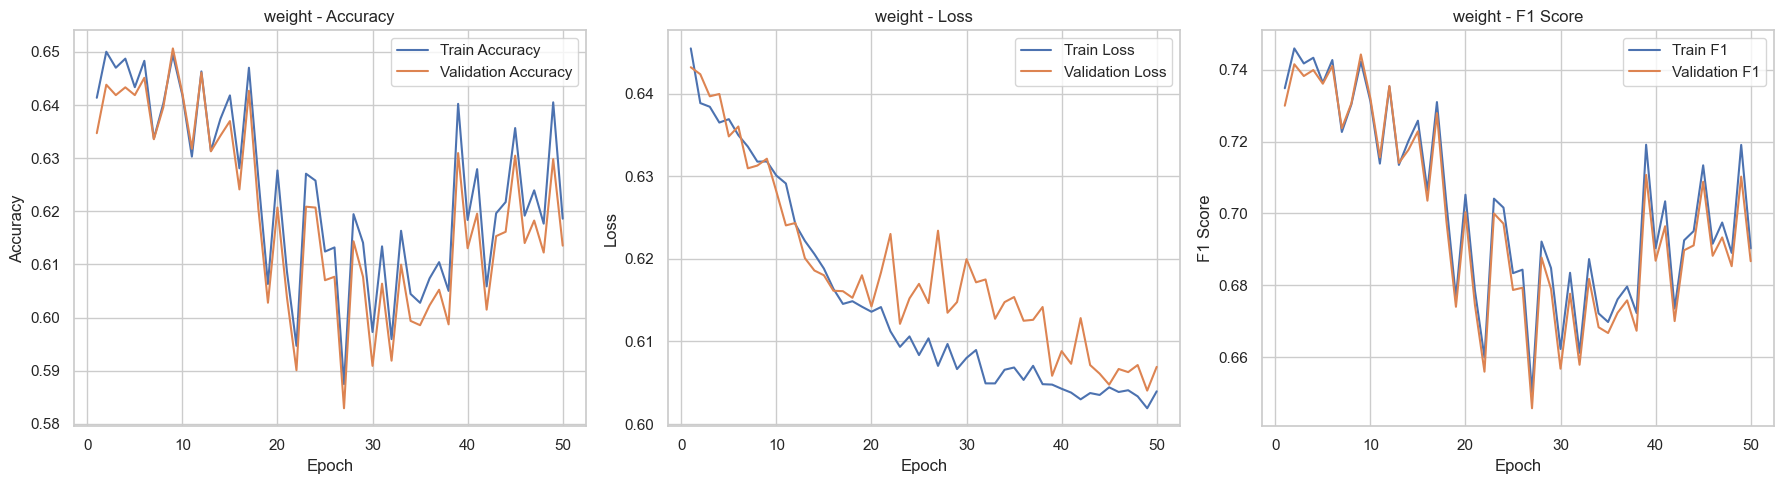

In [234]:
model_comparison.plot_training_curves("../Results/target/gat_results/weight/training_log.csv", model_name= "weight")

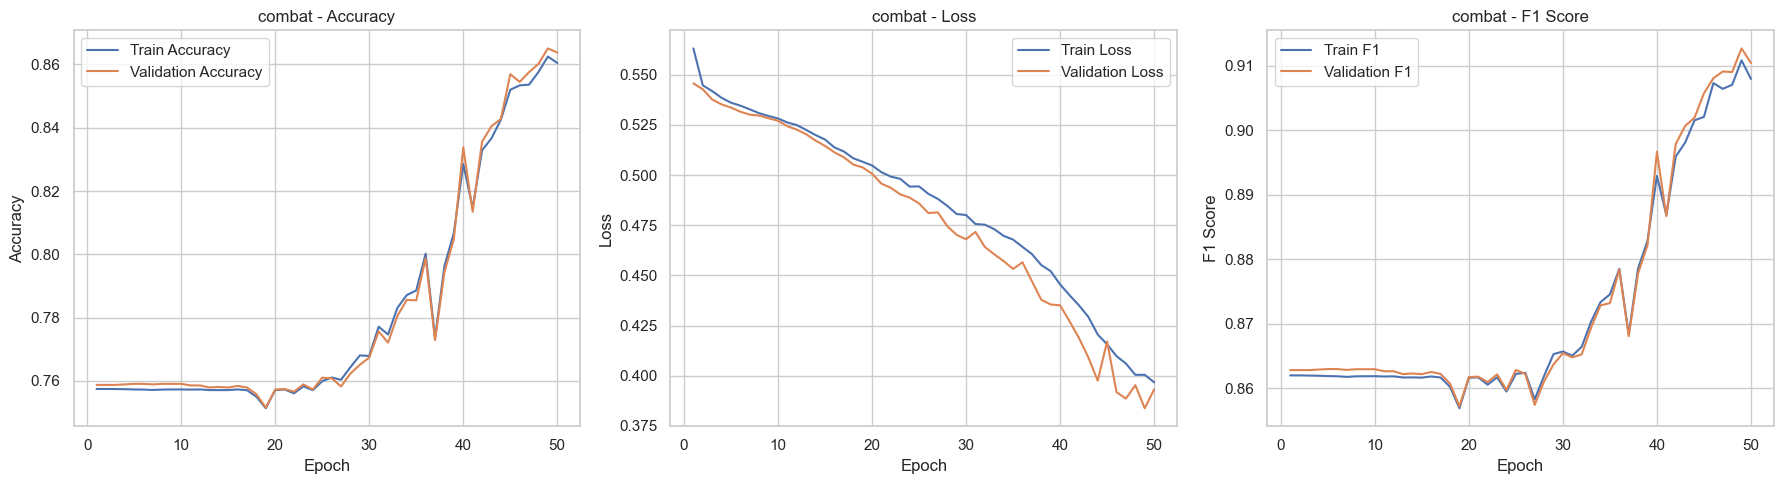

In [235]:
model_comparison.plot_training_curves("../Results/target/gat_results/combat/training_log.csv", model_name= "combat")

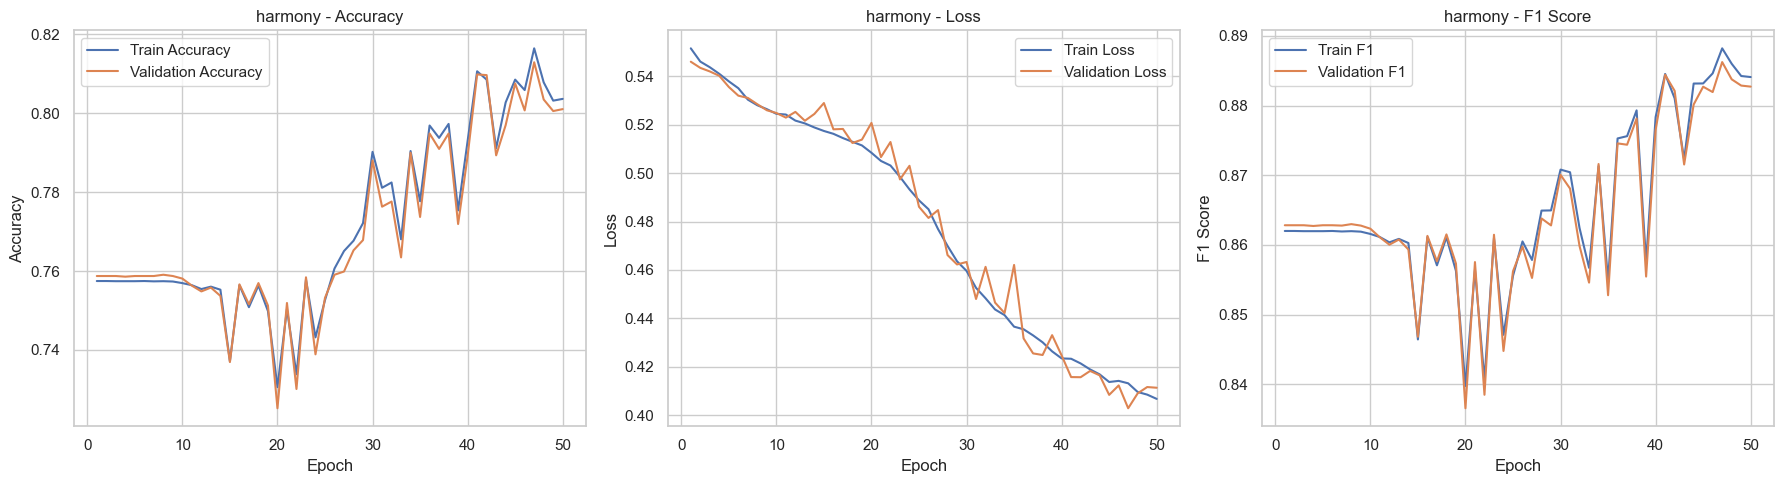

In [236]:
model_comparison.plot_training_curves("../Results/target/gat_results/harmony/training_log.csv", model_name= "harmony")

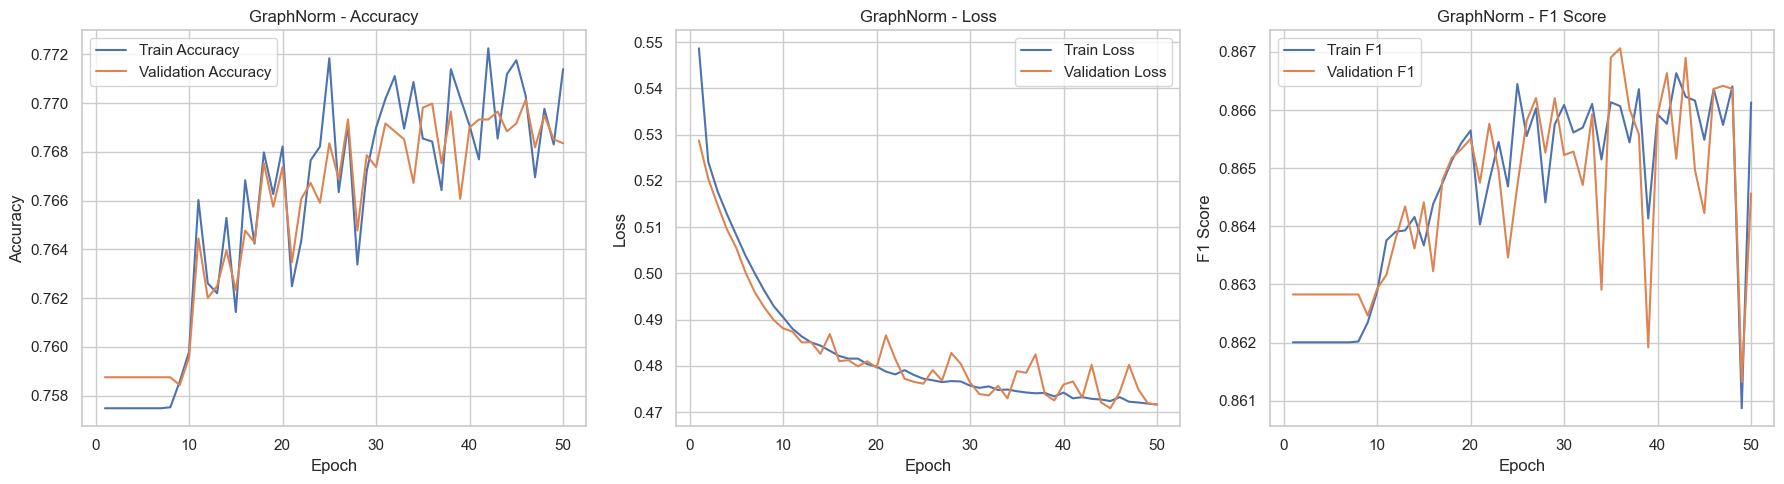

In [237]:
model_comparison.plot_training_curves("../Results/target/gat_results/GraphNorm/training_log.csv", model_name= "GraphNorm")

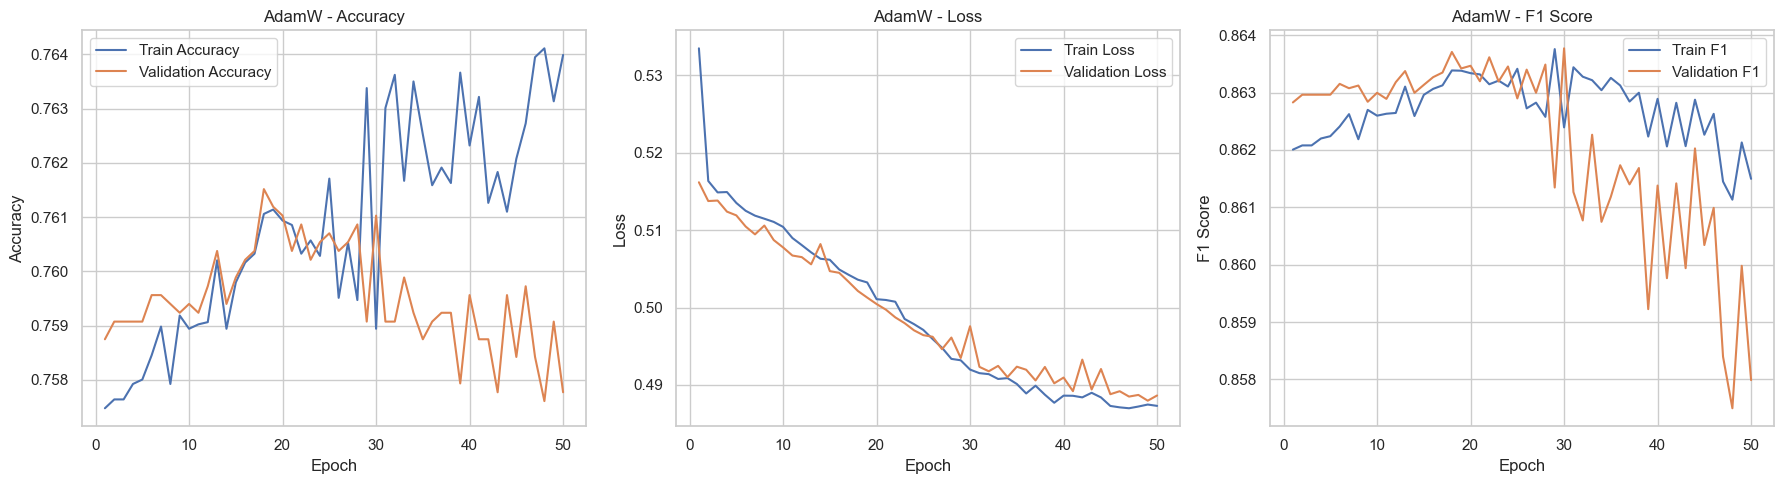

In [238]:
model_comparison.plot_training_curves("../Results/target/gat_results/AdamW/training_log.csv", model_name= "AdamW")

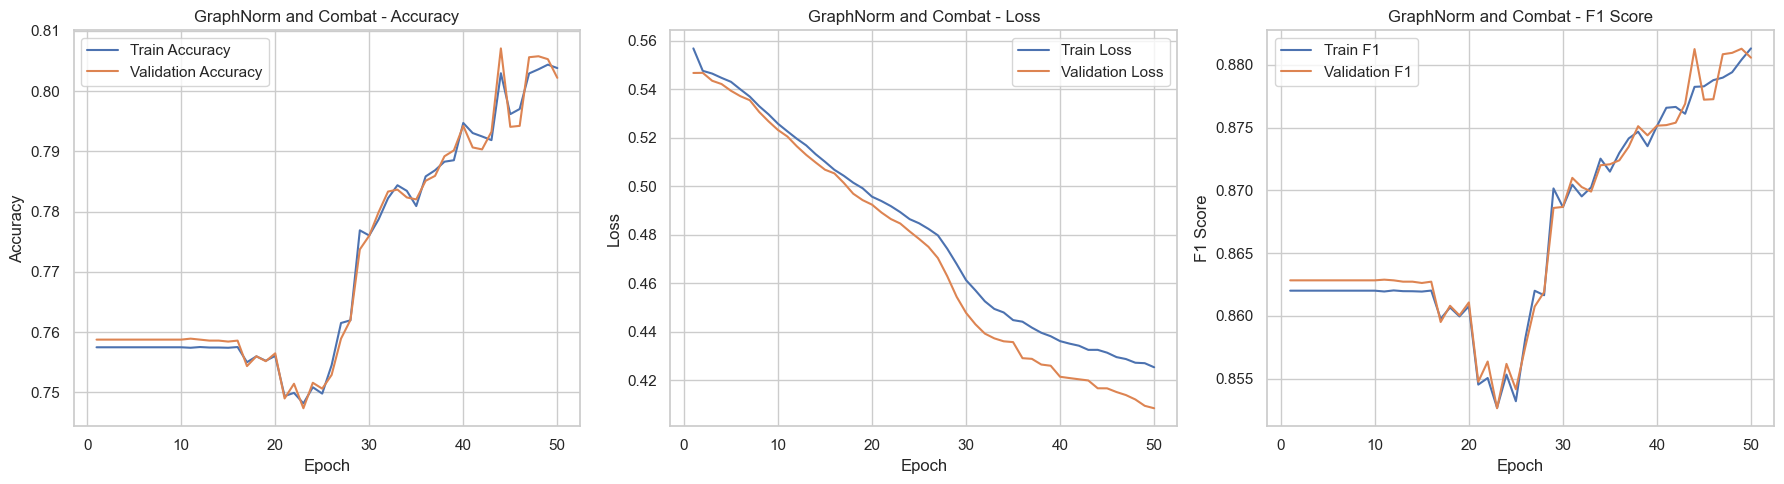

In [239]:
model_comparison.plot_training_curves("../Results/target/gat_results/GraphNorm_combat/training_log.csv", model_name= "GraphNorm and Combat")

### TP53 Target - Fine Tuning

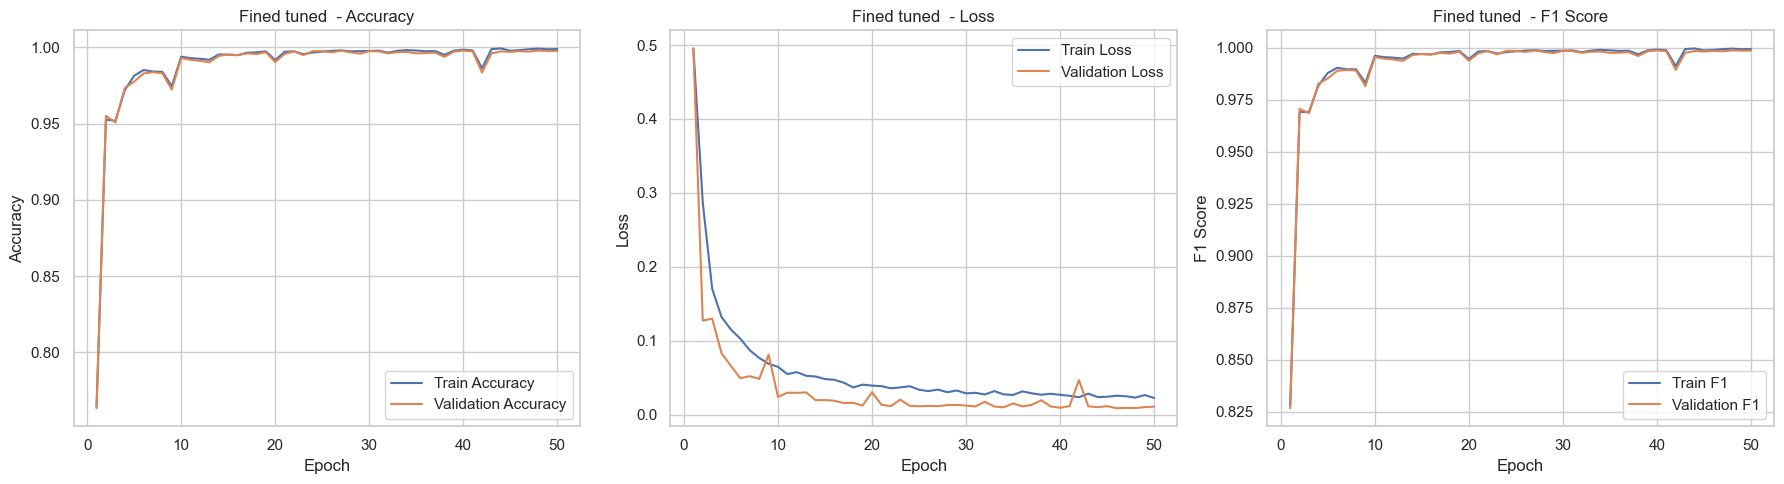

In [240]:
model_comparison.plot_training_curves("../Results/target/gat_results/optuna_17/training_log.csv", model_name= "Fined tuned ")

# # EXTRA 1: Comparison of mutation status between CCLE (22q2) and tp53.cancer.gov (R21 Jan, 2025)

In [241]:
cell_line_status_22q2={'BT474': 'MUT',
 'BT483': 'MUT',
 'BT549': 'MUT',
 'CAL51': 'WT',
 'CAL851': 'MUT',
 'CAMA1': 'MUT',
 'DU4475': 'WT',
 'EFM19': 'MUT',
 'EVSAT': 'MUT',
 'HCC1143': 'MUT',
 'HCC1187': 'MUT',
 'HCC1500': 'WT',
 'HCC1937': 'MUT',
 'HCC1954': 'MUT',
 'HCC38': 'MUT',
 'HCC70': 'MUT',
 'HDQP1': 'MUT',
 'HS578T': 'MUT',
 'JIMT1': 'MUT',
 'KPL1': 'WT',
 'MCF12A': 'WT',
 'MCF7': 'WT',
 'MDAMB361': 'MUT',
 'MDAMB415': 'MUT',
 'MDAMB436': 'MUT',
 'MDAMB453': 'WT',
 'MDAMB468': 'MUT',
 'MX1': 'WT',
 'T47D': 'MUT',
 'ZR751': 'WT'}

In [242]:
df_conf= pd.read_csv("final_preprocessed_data_HVG_.csv",index_col=0)
df_conf["cell_line"] = df_conf.index.str.split("_").str[0]
cell_line_status_R21 = df_conf.groupby("cell_line")["mutation_status"].first().to_dict()

In [243]:
common_keys = set(cell_line_status_R21) & set(cell_line_status_22q2)
matching = {k: cell_line_status_R21[k] for k in common_keys if cell_line_status_R21[k] == cell_line_status_22q2[k]}
non_matching = {k: (cell_line_status_R21[k], cell_line_status_22q2[k]) for k in common_keys if cell_line_status_R21[k] != cell_line_status_22q2[k]}
only_in_dict1 = set(cell_line_status_R21) - set(cell_line_status_22q2)
only_in_dict2 = set(cell_line_status_22q2) - set(cell_line_status_R21)

print("Match perfetti:")
print(matching)

print(" Non corrispondenti:")
print(non_matching)

print("Presenti solo in R21:")
print(only_in_dict1)

print("Presenti solo in 22q2:")
print(only_in_dict2)

Match perfetti:
{'CAL851': 'MUT', 'BT474': 'MUT', 'MDAMB415': 'MUT', 'DU4475': 'WT', 'HCC70': 'MUT', 'JIMT1': 'MUT', 'MDAMB468': 'MUT', 'KPL1': 'WT', 'MDAMB361': 'MUT', 'HCC38': 'MUT', 'MDAMB436': 'MUT', 'HCC1954': 'MUT', 'T47D': 'MUT', 'BT483': 'MUT', 'HCC1937': 'MUT', 'CAMA1': 'MUT', 'BT549': 'MUT', 'HDQP1': 'MUT', 'CAL51': 'WT', 'EFM19': 'MUT', 'HCC1500': 'WT', 'ZR751': 'WT', 'EVSAT': 'MUT', 'MCF7': 'WT'}
 Non corrispondenti:
{'HCC1187': ('WT', 'MUT'), 'HCC1143': ('WT', 'MUT')}
Presenti solo in R21:
{'BT20', 'AU565'}
Presenti solo in 22q2:
{'MDAMB453', 'HS578T', 'MCF12A', 'MX1'}
